# Network Models(Paper) - uses Average A matrix 

**DATA WEBSITES/INFORMATION**

*Where is the data from?*

**Cases**: https://github.com/nytimes/covid-19-data/tree/master/rolling-averages 
> Raw Files: 
https://raw.githubusercontent.com/nytimes/covid-19-data/master/rolling-averages/us-counties-2020.csv
https://raw.githubusercontent.com/nytimes/covid-19-data/master/rolling-averages/us-counties-2021.csv
https://raw.githubusercontent.com/nytimes/covid-19-data/master/rolling-averages/us-counties-2022.csv

    CSV: us-counties-2020.csv, us-counties-2021.csv, us-counties-2022.csv    

**Vaccines**: 
URL: https://data.cdc.gov/Vaccinations/COVID-19-Vaccinations-in-the-United-States-County/8xkx-amqh 

    CSV: COVID-19_Vaccinations_in_the_United_States_County.csv

**Delta Prevalence**: 
URL: https://covid.cdc.gov/covid-data-tracker/#variant-proportions 

    CSV: RegionsDashboard.csv

**Daily Flows**: 
URL: https://github.com/GeoDS/COVID19USFlows-DailyFlows/tree/master/daily_flows/county2county

*Date Range: 01/21/2020 to 04/15/2021*

**County population data:**

URL: https://usafacts.org/visualizations/coronavirus-covid-19-spread-map/state/new-york

    CSV: covid_county_population_usafacts.csv


**We were missing data for counties listed below**

*9 counties we have daily flows for but we do not have case data for* – 02060 (Bristol Bay, Alaska), 02105 (Hoonah-Angoon Census Area, Alaska), 02164 (Lake and Peninsula Borough, Alaska), 02282 (Yakutat, Alaska), 36005 (Bronx County, New York), 36047 (Kings County, New York), 36061 (New York County, New York), 36081 (Queens County, New York), 36085 (Richmond County, New York)

**Case data for missing counties:** 

URL: https://usafacts.org/visualizations/coronavirus-covid-19-spread-map/state/new-york

    CSV: covid_confirmed_usafacts.csv

## SEIR Models

The recursive expressions for the way the disease spreads are given by these expressions (in all of the following, $N$ is the total number of people in the population, so $N=S_{t}+I_{t}+R_{t}$):


$$S(t+1) = S(t) - (E(t+1) - E(t) + \eta E(t)) - \omega V(t) $$ 

$$E(t) = C(t) * \frac{1}{\eta} $$ 
**Note:** C(t) are cases at t 

$$I(t+1) = I(t) + C(t) - \gamma I(t)$$

$$R(t+1) = R(t) + \gamma I(t) + \omega V(t)$$

$$\beta(t) = \frac{(\frac{C(t+1)}{\eta} - \frac{C(t)}{\eta} + C(t))}{diag(S(t))\tilde{A}^Tdiag(\frac{1}{N})I(t)} $$ 


**Note:** The $\tilde{A}^T$ matrices are saved in a folder called 'A Matrices', they have already been transposed and only need to be read in as they are saved in a CSV

## N = a matrix of populations for each county   

## #of people who get sick today  
\begin{align*}
\beta diag(S(t))ANI(t) \\ 
\end{align*}

## #fraction of people currently infected 
\begin{align*}
\frac{I_{t}}{N} \\ 
\end{align*}

## #of contacts between S and I, or likelihood of a contact 
\begin{align*}
\frac{S_{t}I_{t}}{N} \\ 
\end{align*}

## #of people who have recovered  
\begin{align*}
\gamma I_{t} \
\end{align*}

## #of people vaccinated on day $t$
$$ V_t $$

## fraction of vaccinated people who become immune
$$ \omega\in[0,1]$$

## # of Cases on t + D day, D = incubation Delay
\begin{align*}
\eta E_t \\ 
\end{align*} 
Cases today equals the E_t value,but D days ago

## Share of susceptible
\begin{align*}
\frac{Susceptible}{N} \\ 
\end{align*}
 
## # of SI contacts
$$ \#\ of\ infected * share\ of\ susceptible $$

## # of new cases in B (where A is the origin and B is the destination) 
\begin{align*}
\beta * \#\ of\ SI\ contacts \\ 
\end{align*} 

In [1]:
#below are the packages I will be using
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates
from matplotlib.dates import DateFormatter
from datetime import datetime, timedelta, date
from itertools import product
from numpy import linalg as linalg
from collections import OrderedDict
import itertools 

#below are packages for regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from matplotlib.pyplot import figure
from sklearn.linear_model import Ridge
import sklearn
from itertools import cycle, islice 
%matplotlib inline  
pd.options.mode.chained_assignment = None
from statistics import mean
import math

# Path Variables
The default path is the GitHub descon-uccs/pandemic-data repository 

In [93]:
#file path for the input Final_Paper_Data_avg_cases_with_New_York_City CSV
inputFilepath1 = '../Data/Jupyter Notebook Input/Final_Paper_Data_avg_cases_with_New_York_City.csv'

#file path for the output data files that are creates
outputFilepath = '../Data/Data Jupyter Notebooks Build/'

#file path for the input data files
inputFilepath2 = '../Data/Data Jupyter Notebooks Build/'

#Average A matrix file path
averageAMatrixFilepath = '../Data/Average A Matrix/Average_A_matrix.csv'

#Daily A matrix file path
dailyAMatrixFilepath = '../Data/Aggregated A Matrix/Daily_A_matrix.csv'

#file path for the beta vs. sum of mobility scatter plots
scatterPlotFilePath = '../beta_vs_sum_of_mobility_scatter_plot_data/'

# Flag
Below is a flag where

   if **run_flag = True** - will run the code that creates matrices for cases, vaccines, populations and beta values
    
    
   if **run_flag = False** - will not run the code that takes a while to create data matrices and will rather read the 
                               data in from previously created CSVs

In [77]:
run_flag = False

# Parameters

In [3]:
incubation_delay = 4

gamma = 0.1
omega = 0.9
eta = 0.25

## Functions for Data

In [4]:
def get_x_axis_dates(dates):
    x_axis_indices = []
    first_of_each_month_indices = []
    
    temp_xdates = pd.to_datetime(dates, format='%Y-%m-%d').to_list()
    
    #below I get the index of the first day of each month
    for i in temp_xdates:
        if (i.day == 1):
            x_axis_indices.append(temp_xdates.index(i))
            first_of_each_month_indices.append(temp_xdates.index(i))
    
    #below I get the index of the last day of each month 
    last_of_each_month = pd.date_range(dates_Array[0], dates_Array[-1], freq='1M')
    for i in last_of_each_month:
        x_axis_indices.append(temp_xdates.index(i))
    
    x_axis_indices.sort()
    
    x_axis_dates = []
    
    for index in x_axis_indices:
        x_axis_dates.append(dates[index])
    
    return x_axis_indices, first_of_each_month_indices, x_axis_dates

In [5]:
#below is a function to graph various regions and indicies 
colorList = ["r-", "tab:orange", "y-", "g-", "b-", "c-", "xkcd:sky blue", "aquamarine", "tab:blue", "tab:purple", "m-", "tab:pink", "tab:brown", "tab:olive", "k-"]

colors_cycle = cycle(colorList)

def next_color_for_graph():
    return next(colors_cycle)

def graph_data(desired_region, desired_data, dates_Array, St_matrix, It_matrix, Rt_matrix, beta_matrix, Et_matrix, FIPS_dictionary):  
    
    fig, ax = plt.subplots(figsize=(15,10))
    
    axis_index, first_axis_index, first_last_axis_dates = get_x_axis_dates(dates_Array)
    ax.set_xticks(first_axis_index)
    
    first_dates = (pd.date_range(dates_Array[15], dates_Array[-1], freq='1M') - pd.offsets.MonthBegin(1)).strftime('%Y-%m-%d').to_list()
    first_dates.append(dates_Array[-11])
    
    ax.set_xticklabels(first_dates)
    
    region_row = county_FIPS_lookup(FIPS_dictionary, regions_Array_List, 'row', 'Region', desired_region[0])
    
    if(desired_data == 'SIR'): 
        
        plt.plot(St_matrix[region_row, :], label = str(desired_region[0]) + " - S_t+1")
        plt.plot(It_matrix[region_row, :], label = str(desired_region[0]) + " - I_t+1")
        plt.plot(Rt_matrix[region_row, :], label = str(desired_region[0]) + " - R_t+1")
        
        max_y_value = ax.get_ylim()[1]
        
        #below is code to create light and dark bars for where a month starts and ends
        ax.bar(0, max_y_value, color='lightgrey', width=14, align='edge')
        x = 1
        for i in range(7):
            width_value = (first_axis_index[x+1] - 1) - first_axis_index[x]
            ax.bar(first_axis_index[x], max_y_value, color='lightgrey', width=width_value, align='edge')
            x = x + 2
        
        plt.legend(loc="upper left")
        plt.title('SIR Models')   
        plt.ylabel('People')
        plt.xlabel('Day of Covid')
        plt.xticks(rotation = 90)
        plt.legend()
    
    if(desired_data == 'beta'):
        
        for region in desired_region:
            region_row = county_FIPS_lookup(FIPS_dictionary, regions_Array_List, 'row', 'Region', region)
            plt.plot(beta_matrix[region_row, :], label = str(region) + " - beta")
        
        max_y_value = ax.get_ylim()[1]
        
        #below is code to create light and dark bars for where a month starts and ends
        ax.bar(0, max_y_value, color='lightgrey', width=14, align='edge')
        x = 1
        for i in range(7):
            width_value = (first_axis_index[x+1] - 1) - first_axis_index[x]
            ax.bar(first_axis_index[x], max_y_value, color='lightgrey', width=width_value, align='edge')
            x = x + 2
        
        plt.legend(loc="upper left")
        plt.title('How Contagious is COVID-19 on a Given Day')
        plt.ylabel('\u03B2 (beta)')
        plt.xlabel('Day of Covid')
        plt.xticks(rotation = 90)
        plt.legend()
            
    plt.show() 

In [6]:
#below is a function to place the S,I,R,beta,V values that are calculated into a new data frame
def data_to_CSV(data_dict, newFile, data_df):
    all_S_Arrays = np.array([])
    all_I_Arrays = np.array([])
    all_R_Arrays = np.array([])
    all_beta_Arrays = np.array([])
    all_V_Arrays = np.array([])
    all_E_Arrays = np.array([])
    df_dates_array = []
    temp_dates = dates_Array
    state_county_array = []
    

    for region in range(0, number_of_regions):
        name_temp = regions_Array_List[region]
        temp_S_Array = data_dict[name_temp][S_idx]
        temp_I_Array = data_dict[name_temp][I_idx]
        temp_R_Array = data_dict[name_temp][R_idx]
        temp_beta_Array = data_dict[name_temp][b_idx]
        temp_V_Array = data_dict[name_temp][V_idx]
        temp_E_Array = data_dict[name_temp][E_idx]
        temp_state_county_array = []
        
        df_dates_array.extend(temp_dates)

        for days in range(days_of_COVID):
            temp_state_county_array.append(name_temp)
        
        all_S_Arrays = np.concatenate((all_S_Arrays, temp_S_Array), axis = None)
        all_I_Arrays = np.concatenate((all_I_Arrays, temp_I_Array), axis = None)
        all_R_Arrays = np.concatenate((all_R_Arrays, temp_R_Array), axis = None)
        all_beta_Arrays = np.concatenate((all_beta_Arrays, temp_beta_Array), axis = None)
        all_V_Arrays = np.concatenate((all_V_Arrays, temp_V_Array), axis = None)
        all_E_Arrays = np.concatenate((all_E_Arrays, temp_E_Array), axis = None)
        state_county_array.extend(temp_state_county_array)
    
    data_df["date"] = df_dates_array
    data_df["state,county"] = state_county_array
    data_df["S_t+1"] = all_S_Arrays  
    data_df["I_t+1"] = all_I_Arrays
    data_df["R_t+1"] = all_R_Arrays
    data_df["beta"] = all_beta_Arrays
    data_df["V_t"] = all_V_Arrays
    data_df["E_t"] = all_E_Arrays
    data_df.to_csv(newFile, header=True, mode = 'w', index = False)

# SEIR FUNCTION
**Define Functions for S, I, R, & beta values**

In [7]:
#below I create a dictionary where keys are fips and the value is the row/column for that particular fips code
def create_matrix_indices_dictionary(matrix_data):
    FIPS_dictionary = {}
    FIPS_list = sorted(set(matrix_data['fips'].tolist()))
    
    i = 0
    for key in FIPS_list:
        FIPS_dictionary[key] = i
        i += 1
        
    return FIPS_dictionary 

In [8]:
#below is a function that implements the E(t) equation
def E_t(cases, eta):
    return cases * (1/eta)

#below is a function that implements the SEIR model equations above 
def SEIR(gamma,eta,omega,incubation_delay,number_of_nodes,timesteps,N_matrix,cases_matrix,vaccine_matrix):
    
    #1st - Calculate E(t) values
    #The E(t) equation does not depend on any S, I, or R values, due to this below I am able to create the entire E(t) matrix
    Et_matrix = E_t(cases_matrix, eta)
    
    #2nd - Calculate S(t+1), I(t+1) and R(t+1) values
    #create 2d arrays for S, I and R, and initialize time step = 0 for S, I, and R, I do not need to change the 
        #I and R array because I_i(0) = 0 as nobody starts out with COVID-19 and  R_i(0) = 0 as nobody starts out with immunity
    St_matrix = np.zeros([number_of_nodes,timesteps]) #rows are counties while columns are timesteps, meaning days of Covid 
    It_matrix = np.zeros_like(St_matrix) 
    Rt_matrix = np.zeros_like(St_matrix) 
    
    #below I initialize the t=0 values, which are 0 for I(0) and R(0), S(0) is the population of each county  
    St_matrix[:, 0] = N_matrix[:, 0]

    for t in range(incubation_delay):
        
        #below I get C(t)
        cases = cases_matrix[:, t] 
        
        new_exposures = Et_matrix[:, t+1] - Et_matrix[:, t] + (eta * Et_matrix[:, t])
        omega_vaccine = omega * vaccine_matrix[:, t]
        heals_amount = gamma * It_matrix[:, t]
        
        St_matrix[:, t+1] = St_matrix[:, t] - new_exposures - omega_vaccine
        It_matrix[:, t+1] = It_matrix[:, t] + cases - heals_amount
        Rt_matrix[:, t+1] = Rt_matrix[:, t] + heals_amount + omega_vaccine
        
    for t in range(incubation_delay, days_of_COVID-1):  
        
        #below I get C(t)
        cases = cases_matrix[:, t] 
        
        new_exposures = Et_matrix[:, t+1] - Et_matrix[:, t] + (eta * Et_matrix[:, t])
        omega_vaccine = omega * vaccine_matrix[:, t]
        heals_amount = gamma * It_matrix[:, t]
        
        St_matrix[:, t+1] = St_matrix[:, t] - new_exposures - omega_vaccine
        It_matrix[:, t+1] = It_matrix[:, t] + cases - heals_amount
        Rt_matrix[:, t+1] = Rt_matrix[:, t] + heals_amount + omega_vaccine
            
    return St_matrix, It_matrix, Rt_matrix, Et_matrix

#below is a function that uses the S, I, R, E values and A matrices to calculate beta values
def find_betas(eta,number_of_nodes,N_matrix,A,timesteps,cases_matrix,St,It):
    
    #The S, I, R and E equations do not depend on beta; therefore, I can calculate beta last once I have all of the S, I, R and E values
        #below I create a 2d array for the beta values
    beta_matrix = np.zeros([number_of_nodes,timesteps-1])
    
    #below I create a variable to hold the diagonal of inverse populations
    diag_inverse_N = np.diag(np.divide(1, N_matrix[:, 0]))
    
    for t in range(days_of_COVID-1): 
        
        cases_today = cases_matrix[:, t]
        cases_tomorrow = cases_matrix[:, t+1] 
        #print(cases_today, cases_tomorrow)
        
        beta_dividend = (cases_tomorrow / eta) - (cases_today / eta) + (cases_today)
        beta_divisor = np.diag(St[:, t]) @ A @ diag_inverse_N @ It[:, t]
        
        beta_matrix[beta_divisor < 1e-20,t] = 1
        beta_matrix[beta_divisor >= 1e-20,t] = beta_dividend[beta_divisor >= 1e-20] / beta_divisor[beta_divisor >= 1e-20]
        
        #beta can get extreamly large, due to this we decided to cap beta at 1
        beta_matrix = np.minimum(1, beta_matrix) 
    
    beta_matrix = np.where(beta_matrix < 0, 0, beta_matrix)
    return beta_matrix   

# Paper Plots Functions

In [9]:
def beta_I_pairs_plot(desired_region, paper_dates, dates_Array, It_matrix, beta_matrix, FIPS_dictionary):  
    
    fig, ax = plt.subplots(figsize=(15,10))
    
    region_row = county_FIPS_lookup(FIPS_dictionary, regions_Array_List, 'row', 'Region', desired_region)
    
    x = It_matrix[region_row, 105:-1]
    y = beta_matrix[region_row, 105:]
    
    #plt.plot(x, y, c = 'limegreen', label = str(desired_region) + ' ' + paper_dates[0] + ' to ' + paper_dates[171])
    #plt.plot(x[:172], y[:172], c = 'green', label = str(desired_region))
    #plt.plot(x[172:], y[172:], c = 'red', label = str(desired_region) + ' ' + paper_dates[172] + ' to ' + paper_dates[-1])
    
    plt.plot(x, y, c = 'forestgreen', label = str(desired_region) + ' ' + paper_dates[0] + ' to ' + paper_dates[56])
    plt.plot(x[57:114], y[57:114], c = 'limegreen', label = str(desired_region) + ' ' + paper_dates[57] + ' to ' + paper_dates[113])
    plt.plot(x[114:171], y[114:171], c = 'lawngreen', label = str(desired_region) + ' ' + paper_dates[114] + ' to ' + paper_dates[169])
    plt.plot(x[170:228], y[170:228], c = 'coral', label = str(desired_region) + ' ' + paper_dates[170] + ' to ' + paper_dates[226])
    plt.plot(x[227:285], y[227:285], c = 'tomato', label = str(desired_region) + ' ' + paper_dates[227] + ' to ' + paper_dates[284])
    plt.plot(x[285:], y[285:], c = 'red', label = str(desired_region) + ' ' + paper_dates[285] + ' to ' + paper_dates[-1])
    
    plt.legend(loc="upper left")
    plt.title('I,\u03B2 pairs from May onwards')
    plt.ylabel('\u03B2 (beta)')
    plt.xlabel('I(t)')
    plt.legend()
            
    plt.show() 

In [10]:
def county_daily_average(desired_region, dates_Array, beta_matrix, FIPS_dictionary):  
    
    fig, ax = plt.subplots(figsize=(15,10))
    
    dates_indices = []
    
    first_dates = (pd.date_range(dates_Array[105], dates_Array[-1], freq='1M') - pd.offsets.MonthBegin(1)).strftime('%Y-%m-%d').to_list()
    first_dates.append(dates_Array[-11])
   
    #below I get the index of the first day of each month
    for i in first_dates:
        dates_indices.append(paper_dates.index(i))
    
    ax.set_xticks(dates_indices)
    ax.set_xticklabels(first_dates)
    
    region_rows = []
    label_name = ' '
    for region in desired_region:
        region_row = county_FIPS_lookup(FIPS_dictionary, regions_Array_List, 'row', 'Region', region)
        region_rows.append(region_row)
        label_name = label_name + str(region) + ' '
    
    plt.plot(np.average(beta_matrix[region_rows, 105:], axis=0), label = label_name + " - Average \u03B2")

    max_y_value = ax.get_ylim()[1]
      
    #below is code to create light and dark bars for where a month starts and ends
    x = 0
    for i in range(6):
        width_value = (dates_indices[x+1] - 1) - dates_indices[x]
        ax.bar(dates_indices[x], max_y_value, color='lightgrey', width=width_value, align='edge')
        x = x + 2
    
    plt.legend(loc="upper left")
    plt.title('Daily Average for \u03B2 for Counties')
    plt.ylabel('\u03B2 (beta)')
    plt.xlabel('Day of Covid')
    plt.xticks(rotation = 90)
    plt.legend()
    
    plt.show()

In [11]:
def state_daily_average(temp_beta_state, desired_states, dates_Array, beta_matrix, FIPS_dictionary):  
    
    fig, ax = plt.subplots(figsize=(15,10))
    
    dates_indices = []
    
    first_dates = (pd.date_range(dates_Array[105], dates_Array[-1], freq='1M') - pd.offsets.MonthBegin(1)).strftime('%Y-%m-%d').to_list()
    first_dates.append(dates_Array[-11])
   
    #below I get the index of the first day of each month
    for i in first_dates:
        dates_indices.append(paper_dates.index(i))
    
    ax.set_xticks(dates_indices)
    ax.set_xticklabels(first_dates)
    
    region_rows = list(np.where(np.isin(temp_beta_state, desired_states))[0])
    
    label_name = desired_states[0]
    for state in desired_states[1:]:
        label_name = label_name + ', ' + state  
    
    plt.plot(np.average(beta_matrix[region_rows, 105:], axis=0), label = label_name + " - Average \u03B2")

    max_y_value = ax.get_ylim()[1]
      
    #below is code to create light and dark bars for where a month starts and ends
    x = 0
    for i in range(6):
        width_value = (dates_indices[x+1] - 1) - dates_indices[x]
        ax.bar(dates_indices[x], max_y_value, color='lightgrey', width=width_value, align='edge')
        x = x + 2
    
    plt.legend(loc="upper left")
    plt.title('Daily Average for \u03B2 for States')
    plt.ylabel('\u03B2 (beta)')
    plt.xlabel('Day of Covid')
    plt.xticks(rotation = 90)
    plt.legend()
    
    plt.show()

In [12]:
#use this function to plot daily average beta for x states in North and x states in South, x can be any number including 1
def compare_state_daily_average(temp_beta_state, desired_states1, desired_states2, dates_Array, beta_matrix, FIPS_dictionary):  
    
    fig, ax = plt.subplots(figsize=(15,10))
    
    dates_indices = []
    
    first_dates = (pd.date_range(dates_Array[105], dates_Array[-1], freq='1M') - pd.offsets.MonthBegin(1)).strftime('%Y-%m-%d').to_list()
    first_dates.append(dates_Array[-11])
   
    #below I get the index of the first day of each month
    for i in first_dates:
        dates_indices.append(paper_dates.index(i))
    
    ax.set_xticks(dates_indices)
    ax.set_xticklabels(first_dates)
    
    region_rows1 = list(np.where(np.isin(temp_beta_state, desired_states1))[0])
    region_rows2 = list(np.where(np.isin(temp_beta_state, desired_states2))[0])
    
    label_name1 = desired_states1[0]
    for state in desired_states1[1:]:
        label_name1 = label_name1 + ', ' + state
    
    label_name2 = desired_states2[0]
    for state in desired_states2[1:]:
        label_name2 = label_name2 + ', ' + state
    
    plt.plot(np.average(beta_matrix[region_rows1, 105:], axis=0), label = label_name1 + " - Average \u03B2")
    plt.plot(np.average(beta_matrix[region_rows2, 105:], axis=0), label = label_name2 + " - Average \u03B2")

    max_y_value = ax.get_ylim()[1]
      
    #below is code to create light and dark bars for where a month starts and ends
    x = 0
    for i in range(6):
        width_value = (dates_indices[x+1] - 1) - dates_indices[x]
        ax.bar(dates_indices[x], max_y_value, color='lightgrey', width=width_value, align='edge')
        x = x + 2
    
    plt.legend(loc="upper left")
    plt.title('Daily Average for \u03B2 for States')
    plt.ylabel('\u03B2 (beta)')
    plt.xlabel('Day of Covid')
    plt.xticks(rotation = 90)
    plt.legend()
    
    plt.show()

In [13]:
def beta_sum_of_mobility_plot(desired_region, paper_dates, sum_of_mobility_matrix, beta_matrix, FIPS_dictionary):  
    
    fig, ax = plt.subplots(figsize=(15,10))
    
    region_row = county_FIPS_lookup(FIPS_dictionary, regions_Array_List, 'row', 'Region', desired_region)
    
    #have to slice sum_of_mobility_matrix from 105 to the second to last column because beta is short of 1 date
    x = sum_of_mobility_matrix[region_row, 105:-1]
    y = beta_matrix[region_row, 105:]
    
    plt.scatter(x, y, c = 'forestgreen', label = str(desired_region))
    
    plt.legend(loc="upper left")
    plt.title('\u03B2 vs. Sum of Mobility from May onwards')
    plt.ylabel('\u03B2 (beta)')
    plt.xlabel('sum of mobility')
    plt.legend()
            
    plt.show() 

In [100]:
#function to put beta vs. sum_of_mobility scatter plot data of a county into a CSV
def create_CSV_of_beta_sum_of_mobility_data(desired_region, paper_dates, sum_of_mobility_matrix, beta_matrix, FIPS_dictionary):  
    
    region_row = county_FIPS_lookup(FIPS_dictionary, regions_Array_List, 'row', 'Region', desired_region)
    
    #have to slice sum_of_mobility_matrix from 105 to the second to last column because beta is short of 1 date
    x = sum_of_mobility_matrix[region_row, 105:-1]
    y = beta_matrix[region_row, 105:]
    
    region_list = [desired_region] * len(x)

    data_df = pd.DataFrame({'Date': paper_dates[:-1], '(State, County)': region_list, 'Sum of Mobility': x, 'Beta': y})
    
    data_df.to_csv(scatterPlotFilePath + "beta_vs_sum_of_mobility_data_" + str(desired_region) + ".csv")

    print("Complete!")

In [15]:
def split_beta_sum_of_mobility_plot(desired_region, paper_dates, sum_of_mobility_matrix, beta_matrix, FIPS_dictionary):  
    
    fig, ax = plt.subplots(figsize=(15,10))
    
    region_row = county_FIPS_lookup(FIPS_dictionary, regions_Array_List, 'row', 'Region', desired_region)
    
    #have to slice sum_of_mobility_matrix from 105 to the second to last column because beta is short of 1 date
    x = sum_of_mobility_matrix[region_row, 105:-1]
    y = beta_matrix[region_row, 105:]
    
    plt.scatter(x, y, c = 'green', label = str(desired_region) + ' ' + paper_dates[0] + ' to ' + paper_dates[171])
    plt.scatter(x[172:], y[172:], c = 'red', label = str(desired_region) + ' ' + paper_dates[172] + ' to ' + paper_dates[-1])
    
    plt.legend(loc="upper left")
    plt.title('Split \u03B2 vs. Sum of Mobility from May onwards')
    plt.ylabel('\u03B2 (beta)')
    plt.xlabel('sum of mobility')
    plt.legend()
            
    plt.show() 

In [16]:
def daily_mobility_plot(desired_region, dates_Array, sum_of_mobility_matrix, FIPS_dictionary):  
    
    fig, ax = plt.subplots(figsize=(15,10))
    
    dates_indices = []
    
    first_dates = (pd.date_range(dates_Array[105], dates_Array[-1], freq='1M') - pd.offsets.MonthBegin(1)).strftime('%Y-%m-%d').to_list()
    first_dates.append(dates_Array[-11])
   
    #below I get the index of the first day of each month
    for i in first_dates:
        dates_indices.append(paper_dates.index(i))
    
    ax.set_xticks(dates_indices)
    ax.set_xticklabels(first_dates)
    
    region_row = county_FIPS_lookup(FIPS_dictionary, regions_Array_List, 'row', 'Region', desired_region)
    
    plt.plot(sum_of_mobility_matrix[region_row, 105:], label = str(desired_region) + " - Outgoing Flows")

    max_y_value = ax.get_ylim()[1]
      
    #below is code to create light and dark bars for where a month starts and ends
    x = 0
    for i in range(6):
        width_value = (dates_indices[x+1] - 1) - dates_indices[x]
        ax.bar(dates_indices[x], max_y_value, color='lightgrey', width=width_value, align='edge')
        x = x + 2
    
    ax.set_ylim(ymin = min(list(sum_of_mobility_matrix[region_row, 105:])))
    
    plt.legend(loc="upper left")
    plt.title('Daily Mobility')
    plt.ylabel('Mobility')
    plt.xlabel('Day of Covid')
    plt.xticks(rotation = 90)
    plt.legend()
    
    plt.show()

## A Lookup - for FIPS, Matrix Rows, and Regions
Examples of how to use - 

**Function: county_FIPS_lookup(FIPS_dictionary, regions_Array_List, desired_parameter, input_type, input_value)**

county_FIPS_lookup(FIPS_dictionary, regions_Array_List, 'row', 'FIPS', 35025)

county_FIPS_lookup(FIPS_dictionary, regions_Array_List, 'row', 'Region', regions_Array_List[1])

county_FIPS_lookup(FIPS_dictionary, regions_Array_List, 'row', 'Region', ('New Mexico', 'Guadalupe'))

county_FIPS_lookup(FIPS_dictionary, regions_Array_List, 'FIPS', 'Row', 10)

county_FIPS_lookup(FIPS_dictionary, regions_Array_List, 'FIPS', 'Region', ('New Mexico', 'Guadalupe'))

county_FIPS_lookup(FIPS_dictionary, regions_Array_List, 'region', 'Row', 10)

county_FIPS_lookup(FIPS_dictionary, regions_Array_List, 'region', 'FIPS', 35019)

In [17]:
def county_FIPS_lookup(FIPS_dictionary, regions_Array_List, desired_parameter, input_type, input_value):
    values_list = list(FIPS_dictionary.values())
    keys_list = list(FIPS_dictionary.keys())
    temp_df = pd.DataFrame({'Row': values_list, 'FIPS': keys_list, 'Region': regions_Array_List})
    
    if(desired_parameter == 'row'):
        if(input_type == 'FIPS'):
            df_row = temp_df[temp_df['FIPS'] == input_value]
            matrix_row = df_row.iloc[0]['Row']
            return matrix_row
        else:
            df_row = temp_df[temp_df['Region'] == input_value]
            matrix_row = df_row.iloc[0]['Row']
            return matrix_row
    
    if(desired_parameter == 'FIPS'):
        if(input_type == 'Row'):
            df_row = temp_df[temp_df['Row'] == input_value]
            FIPS = df_row.iloc[0]['FIPS']
            return FIPS
        else:
            df_row = temp_df[temp_df['Region'] == input_value]
            FIPS = df_row.iloc[0]['FIPS']
            return FIPS
        
    if(desired_parameter == 'region'):
        if(input_type == 'Row'):
            df_row = temp_df[temp_df['Row'] == input_value]
            FIPS = df_row.iloc[0]['Region']
            return FIPS
        else:
            df_row = temp_df[temp_df['FIPS'] == input_value]
            FIPS = df_row.iloc[0]['Region']
            return FIPS      

## Start Reading In Data

In [46]:
#The only requirement is that the CSV file and this notebook are in the same location 
fileName = inputFilepath1
dataset = pd.read_csv(fileName)
dataset 

date   fips    state   county  cases  vaccinations  population
0        2020-03-24   1001  Alabama  Autauga   0.14             0       55869
1        2020-03-25   1001  Alabama  Autauga   0.57             0       55869
2        2020-03-26   1001  Alabama  Autauga   0.86             0       55869
3        2020-03-27   1001  Alabama  Autauga   0.86             0       55869
4        2020-03-28   1001  Alabama  Autauga   0.86             0       55869
...             ...    ...      ...      ...    ...           ...         ...
1185483  2021-04-11  56045  Wyoming   Weston   0.75          1379        6927
1185484  2021-04-12  56045  Wyoming   Weston   0.86          1379        6927
1185485  2021-04-13  56045  Wyoming   Weston   0.88          1380        6927
1185486  2021-04-14  56045  Wyoming   Weston   1.00          1392        6927
1185487  2021-04-15  56045  Wyoming   Weston   1.00          1392        6927

[1185488 rows x 7 columns]

In [22]:
dataset[dataset["fips"]== 36998] #for New York City County

date   fips     state         county    cases  vaccinations  \
711494  2020-03-01  36998  New York  New York City     0.14             0   
711495  2020-03-02  36998  New York  New York City     0.14             0   
711496  2020-03-03  36998  New York  New York City     0.29             0   
711497  2020-03-04  36998  New York  New York City     0.29             0   
711498  2020-03-05  36998  New York  New York City     0.57             0   
...            ...    ...       ...            ...      ...           ...   
711900  2021-04-11  36998  New York  New York City  3415.14       1782818   
711901  2021-04-12  36998  New York  New York City  3380.43       1823908   
711902  2021-04-13  36998  New York  New York City  3247.29       1867765   
711903  2021-04-14  36998  New York  New York City  3247.00       1901552   
711904  2021-04-15  36998  New York  New York City  3055.00       1933866   

        population  
711494     8336817  
711495     8336817  
711496     8336817  
711497     8336817  
711498     8336817  
...            ...  
711900     8336817  
711901     8336817  
711902     8336817  
711903     8336817  
711904     8336817  

[411 rows x 7 columns]

**Prepare Data**

In [23]:
df_daily_change_normal_index = dataset.loc[:, ['date', 'fips', 'state', 'county', 'cases', 'population']]

#code below creates a series - to get daily vaccinations 
series_daily_vaccines = dataset.groupby(['state','county'])['vaccinations'].diff().fillna(0)
daily_vaccines_df = series_daily_vaccines.to_frame()
df_daily_change_normal_index.insert(5, "vaccinations", daily_vaccines_df)
df_daily_change_normal_index

date   fips    state   county  cases  vaccinations  population
0        2020-03-24   1001  Alabama  Autauga   0.14           0.0       55869
1        2020-03-25   1001  Alabama  Autauga   0.57           0.0       55869
2        2020-03-26   1001  Alabama  Autauga   0.86           0.0       55869
3        2020-03-27   1001  Alabama  Autauga   0.86           0.0       55869
4        2020-03-28   1001  Alabama  Autauga   0.86           0.0       55869
...             ...    ...      ...      ...    ...           ...         ...
1185483  2021-04-11  56045  Wyoming   Weston   0.75         120.0        6927
1185484  2021-04-12  56045  Wyoming   Weston   0.86           0.0        6927
1185485  2021-04-13  56045  Wyoming   Weston   0.88           1.0        6927
1185486  2021-04-14  56045  Wyoming   Weston   1.00          12.0        6927
1185487  2021-04-15  56045  Wyoming   Weston   1.00           0.0        6927

[1185488 rows x 7 columns]

In [24]:
dates = dataset["date"]
result = (dates.drop_duplicates()).to_list()
print(min(result), max(result))

2020-01-21 2021-04-15


In [25]:
#below I create a list containing the dates
largest_days_of_COVID_array = []
largest_days_of_COVID_temp = dataset['date'].tolist()

#code below is to remove all duplicates 
largest_days_of_COVID_array = list(dict.fromkeys(largest_days_of_COVID_temp))

#below I sort the string of dates
largest_days_of_COVID_array.sort(key = lambda date: datetime.strptime(date, '%Y-%m-%d'))
#below I save the first date of COVID, many counties do not start reporting cases on this date, due to this I need to 
#make all of the counties start on this date and fill in empty rows with 0's
first_day_of_COVID = largest_days_of_COVID_array[0]
print(first_day_of_COVID)

#Due to the idea that E_t begins D days before the first day of cases, I need to add D number of dates to the beginning 
#of the dates array, below I create a dates_Array that will be used as the x-axis of each graph 
dates_Array = []
dates_Array = largest_days_of_COVID_array
beginningDate = datetime.strptime(dates_Array[0], '%Y-%m-%d') 

for extra_day in range(0, incubation_delay):
    addedDate = beginningDate - timedelta(days=extra_day+1)
    date_time = addedDate.strftime("%#Y-%#m-%d")
    dates_Array.insert(0, date_time)
    dates_Array.pop()

print(dates_Array)

#below I save the largest number of days of COVID, this will be the length of the data dictionary 
days_of_COVID = len(dates_Array)
print(days_of_COVID)

2020-01-21
['2020-1-17', '2020-1-18', '2020-1-19', '2020-1-20', '2020-01-21', '2020-01-22', '2020-01-23', '2020-01-24', '2020-01-25', '2020-01-26', '2020-01-27', '2020-01-28', '2020-01-29', '2020-01-30', '2020-01-31', '2020-02-01', '2020-02-02', '2020-02-03', '2020-02-04', '2020-02-05', '2020-02-06', '2020-02-07', '2020-02-08', '2020-02-09', '2020-02-10', '2020-02-11', '2020-02-12', '2020-02-13', '2020-02-14', '2020-02-15', '2020-02-16', '2020-02-17', '2020-02-18', '2020-02-19', '2020-02-20', '2020-02-21', '2020-02-22', '2020-02-23', '2020-02-24', '2020-02-25', '2020-02-26', '2020-02-27', '2020-02-28', '2020-02-29', '2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04', '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08', '2020-03-09', '2020-03-10', '2020-03-11', '2020-03-12', '2020-03-13', '2020-03-14', '2020-03-15', '2020-03-16', '2020-03-17', '2020-03-18', '2020-03-19', '2020-03-20', '2020-03-21', '2020-03-22', '2020-03-23', '2020-03-24', '2020-03-25', '2020-03-26', '2020-03-27'

**Build Necessary Lists**

In [26]:
#below I create a list containing the names of the counties with what state the county is in to use as keys for the 
#dictionaries
regions_Array_List = []

regions_Array_temp = dataset[['state', 'county']].apply(tuple, axis = 1).tolist()

#code below is to remove all duplicates 
regions_Array_List = list(dict.fromkeys(regions_Array_temp))
regions_Array_List

[('Alabama', 'Autauga'),
 ('Alabama', 'Baldwin'),
 ('Alabama', 'Barbour'),
 ('Alabama', 'Bibb'),
 ('Alabama', 'Blount'),
 ('Alabama', 'Bullock'),
 ('Alabama', 'Butler'),
 ('Alabama', 'Calhoun'),
 ('Alabama', 'Chambers'),
 ('Alabama', 'Cherokee'),
 ('Alabama', 'Chilton'),
 ('Alabama', 'Choctaw'),
 ('Alabama', 'Clarke'),
 ('Alabama', 'Clay'),
 ('Alabama', 'Cleburne'),
 ('Alabama', 'Coffee'),
 ('Alabama', 'Colbert'),
 ('Alabama', 'Conecuh'),
 ('Alabama', 'Coosa'),
 ('Alabama', 'Covington'),
 ('Alabama', 'Crenshaw'),
 ('Alabama', 'Cullman'),
 ('Alabama', 'Dale'),
 ('Alabama', 'Dallas'),
 ('Alabama', 'DeKalb'),
 ('Alabama', 'Elmore'),
 ('Alabama', 'Escambia'),
 ('Alabama', 'Etowah'),
 ('Alabama', 'Fayette'),
 ('Alabama', 'Franklin'),
 ('Alabama', 'Geneva'),
 ('Alabama', 'Greene'),
 ('Alabama', 'Hale'),
 ('Alabama', 'Henry'),
 ('Alabama', 'Houston'),
 ('Alabama', 'Jackson'),
 ('Alabama', 'Jefferson'),
 ('Alabama', 'Lamar'),
 ('Alabama', 'Lauderdale'),
 ('Alabama', 'Lawrence'),
 ('Alabama', '

In [27]:
print("Number of counties we are looking at:",len(regions_Array_List))

Number of counties we are looking at: 3133


In [28]:
#below I create a list containing the names of the counties, some counties have the same name just in a different state,
#due to this I had to use the code below, for instance New Mexico and New Jersey have a county called Union
regions_Array = []

for regions in range(0, len(regions_Array_List)):
    region_name = regions_Array_List[regions][1]
    regions_Array.append(region_name)
    
print(regions_Array)

number_of_regions = len(regions_Array)

print(number_of_regions)

['Autauga', 'Baldwin', 'Barbour', 'Bibb', 'Blount', 'Bullock', 'Butler', 'Calhoun', 'Chambers', 'Cherokee', 'Chilton', 'Choctaw', 'Clarke', 'Clay', 'Cleburne', 'Coffee', 'Colbert', 'Conecuh', 'Coosa', 'Covington', 'Crenshaw', 'Cullman', 'Dale', 'Dallas', 'DeKalb', 'Elmore', 'Escambia', 'Etowah', 'Fayette', 'Franklin', 'Geneva', 'Greene', 'Hale', 'Henry', 'Houston', 'Jackson', 'Jefferson', 'Lamar', 'Lauderdale', 'Lawrence', 'Lee', 'Limestone', 'Lowndes', 'Macon', 'Madison', 'Marengo', 'Marion', 'Marshall', 'Mobile', 'Monroe', 'Montgomery', 'Morgan', 'Perry', 'Pickens', 'Pike', 'Randolph', 'Russell', 'St. Clair', 'Shelby', 'Sumter', 'Talladega', 'Tallapoosa', 'Tuscaloosa', 'Walker', 'Washington', 'Wilcox', 'Winston', 'Aleutians East Borough', 'Aleutians West Census Area', 'Anchorage', 'Bethel Census Area', 'Denali Borough', 'Dillingham Census Area', 'Fairbanks North Star Borough', 'Haines Borough', 'Juneau City and Borough', 'Kenai Peninsula Borough', 'Ketchikan Gateway Borough', 'Kodiak

In [29]:
#below I create a dictionary where keys are the FIPS we decided to look at while 
    #values are the row/column that correspond to each FIPS code
FIPS_dictionary = create_matrix_indices_dictionary(dataset) 

In [30]:
FIPS_dictionary

{1001: 0,
 1003: 1,
 1005: 2,
 1007: 3,
 1009: 4,
 1011: 5,
 1013: 6,
 1015: 7,
 1017: 8,
 1019: 9,
 1021: 10,
 1023: 11,
 1025: 12,
 1027: 13,
 1029: 14,
 1031: 15,
 1033: 16,
 1035: 17,
 1037: 18,
 1039: 19,
 1041: 20,
 1043: 21,
 1045: 22,
 1047: 23,
 1049: 24,
 1051: 25,
 1053: 26,
 1055: 27,
 1057: 28,
 1059: 29,
 1061: 30,
 1063: 31,
 1065: 32,
 1067: 33,
 1069: 34,
 1071: 35,
 1073: 36,
 1075: 37,
 1077: 38,
 1079: 39,
 1081: 40,
 1083: 41,
 1085: 42,
 1087: 43,
 1089: 44,
 1091: 45,
 1093: 46,
 1095: 47,
 1097: 48,
 1099: 49,
 1101: 50,
 1103: 51,
 1105: 52,
 1107: 53,
 1109: 54,
 1111: 55,
 1113: 56,
 1115: 57,
 1117: 58,
 1119: 59,
 1121: 60,
 1123: 61,
 1125: 62,
 1127: 63,
 1129: 64,
 1131: 65,
 1133: 66,
 2013: 67,
 2016: 68,
 2020: 69,
 2050: 70,
 2068: 71,
 2070: 72,
 2090: 73,
 2100: 74,
 2110: 75,
 2122: 76,
 2130: 77,
 2150: 78,
 2158: 79,
 2170: 80,
 2180: 81,
 2185: 82,
 2188: 83,
 2195: 84,
 2198: 85,
 2220: 86,
 2230: 87,
 2240: 88,
 2261: 89,
 2275: 90,
 2290: 91

In [31]:
FIPS_dictionary[36998] #Index for New York City

1880

**Build Necessary Dictionaries**

In [36]:
#Note: this cell takes a little over 35 minutes to run, which is why I added the run_flag, if this flag is True, then 
    #this code will run, otherwise the data will be read in from CSVs that were previously created
if (run_flag == True):
    cases_dict = {}
    vaccine_dict = {}
    population_dict = {}

    for x in range(len(regions_Array)):
        key = regions_Array_List[x]
        state = key[0]
        county = key[1]
        cases_dict[key] = df_daily_change_normal_index.loc[(df_daily_change_normal_index['state'] == state) & (df_daily_change_normal_index['county'] == county), 'cases']
        vaccine_dict[key] = df_daily_change_normal_index.loc[(df_daily_change_normal_index['state'] == state) & (df_daily_change_normal_index['county'] == county), 'vaccinations']
        population_dict[key] = df_daily_change_normal_index.loc[(df_daily_change_normal_index['state'] == state) & (df_daily_change_normal_index['county'] == county), 'population']

        if(len(cases_dict[key]) != days_of_COVID):
            #print(key)
            temp = []
            temp_population = []
            difference_days = days_of_COVID - len(cases_dict[key])
            population = population_dict[key].iloc[0]

            for add_day in range(difference_days):
                temp.append(0)
                temp_population.append(population)
            temp = pd.Series(temp)
            temp_population = pd.Series(temp_population)
            cases_dict[key] = pd.concat([temp, cases_dict[key]])
            vaccine_dict[key] = pd.concat([temp, vaccine_dict[key]])
            population_dict[key] = pd.concat([temp_population, population_dict[key]])

        #below I set the index for each dictionary to state,county for each series
        temp_cases_df = pd.DataFrame(cases_dict[key])
        temp_vaccine_df = pd.DataFrame(vaccine_dict[key])
        temp_population_df = pd.DataFrame(population_dict[key])

        new_index = []

        for x in range(days_of_COVID):
            new_index.append(county)

        temp_cases_df["county"]= new_index
        temp_cases_df.columns = ['cases', 'county']
        temp_cases_df.set_index("county", inplace = True)
        cases_dict[key] = temp_cases_df.squeeze()

        temp_vaccine_df["county"]= new_index
        temp_vaccine_df.columns = ['vaccine', 'county']
        temp_vaccine_df.set_index("county", inplace = True)
        vaccine_dict[key] = temp_vaccine_df.squeeze()

        temp_population_df["county"]= new_index
        temp_population_df.columns = ['population', 'county']
        temp_population_df.set_index("county", inplace = True)
        population_dict[key] = temp_population_df.squeeze()

    cases_dict

In [37]:
#below I create a cases matrix
if (run_flag == True):
    cases_matrix = np.zeros((len(regions_Array_List), days_of_COVID))

    i=0
    for region in regions_Array_List:
        for day in range(days_of_COVID):
            cases_matrix[i][day] = cases_dict[region][day]
        i += 1
    cases_matrix

In [38]:
#below I create a vaccine matrix
if (run_flag == True):
    vaccine_matrix = np.zeros((len(regions_Array_List), days_of_COVID))

    i=0
    for region in regions_Array_List:
        for day in range(days_of_COVID):
            vaccine_matrix[i][day] = vaccine_dict[region][day]
        i += 1
    vaccine_matrix

In [39]:
#below I create the N matrix
if (run_flag == True):
    N_matrix = np.zeros((len(regions_Array_List), 1))

    i=0
    for region in regions_Array_List:
        N_matrix[i] = (population_dict[region][0])
        i += 1
    N_matrix

In [49]:
#use the code below to save cases_matrix, vaccine_matrix, and N_matrix in a CSV because it takes a while to get cases_dict, vaccine_dict, and population_dict
    #below I turn the 3 matrices into dataframes, add a column with the FIPS code that corresponds to each row of the matrix and then save it as a CSV
if (run_flag == True):
    
    cols = list(FIPS_dictionary.keys())

    temp_cases_df = pd.DataFrame(cases_matrix)
    temp_cases_df.insert(0, 'FIPS index', cols)
    #temp_cases_df
    temp_cases_df.to_csv(outputFilepath + "cases_matrix.csv") 


    temp_vaccine_df = pd.DataFrame(vaccine_matrix)
    temp_vaccine_df.insert(0, 'FIPS index', cols)
    #temp_vaccine_df
    temp_vaccine_df.to_csv(outputFilepath + "vaccine_matrix.csv")

    temp_N_df = pd.DataFrame(N_matrix)
    temp_N_df.insert(0, 'FIPS index', cols)
    #temp_N_df
    temp_N_df.to_csv(outputFilepath + "N_matrix.csv")
    print("Complete!")

Complete!


In [58]:
#below I get the cases_matrix, vaccine_matrix, and N_matrix using the CSVs that I have saved
if (run_flag == False):
    cases_fileName = outputFilepath + "cases_matrix.csv"
    cases_dataset = pd.read_csv(cases_fileName)
    cases_dataset.drop('Unnamed: 0', inplace=True, axis=1)
    cases_dataset.drop('FIPS index', inplace=True, axis=1)
    cases_matrix = cases_dataset.to_numpy()

    vaccine_fileName = outputFilepath + "vaccine_matrix.csv"
    vaccine_dataset = pd.read_csv(vaccine_fileName)
    vaccine_dataset.drop('Unnamed: 0', inplace=True, axis=1)
    vaccine_dataset.drop('FIPS index', inplace=True, axis=1)
    vaccine_matrix = vaccine_dataset.to_numpy()

    N_fileName = outputFilepath + "N_matrix.csv"
    N_dataset = pd.read_csv(N_fileName)
    N_dataset.drop('Unnamed: 0', inplace=True, axis=1)
    N_dataset.drop('FIPS index', inplace=True, axis=1)
    N_matrix = N_dataset.to_numpy()

In [60]:
cases_matrix

array([[ 0.  ,  0.  ,  0.  , ..., 12.86,  9.29,  6.57],
       [ 0.  ,  0.  ,  0.  , ..., 14.43, 13.86, 12.29],
       [ 0.  ,  0.  ,  0.  , ...,  2.  ,  2.57,  2.57],
       ...,
       [ 0.  ,  0.  ,  0.  , ...,  2.57,  2.57,  1.88],
       [ 0.  ,  0.  ,  0.  , ...,  0.75,  0.75,  0.75],
       [ 0.  ,  0.  ,  0.  , ...,  0.88,  1.  ,  1.  ]])

In [61]:
vaccine_matrix

array([[0.000e+00, 0.000e+00, 0.000e+00, ..., 1.430e+02, 1.090e+02,
        1.440e+02],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.017e+03, 9.260e+02,
        4.350e+02],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 2.600e+01, 5.700e+01,
        2.000e+01],
       ...,
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.400e+01, 3.300e+01,
        4.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 1.500e+01,
        1.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.000e+00, 1.200e+01,
        0.000e+00]])

In [62]:
N_matrix

array([[ 55869.],
       [223234.],
       [ 24686.],
       ...,
       [ 20226.],
       [  7805.],
       [  6927.]])

## Calculate S,I,R,beta,E values
Below I calculate S, I, R, and V, E values

Use Function: 

**SEIR(gamma,eta,omega,incubation_delay,number_of_nodes,timesteps,N_matrix,cases_matrix,vaccine_matrix)**


Then I calculate the beta values

Use Function: 

**find_betas(eta,number_of_nodes,N_matrix,A,days_of_COVID,cases_matrix,St,It):**

In [65]:
number_of_nodes = len(regions_Array_List)

#below I calculate the S, I, R, and E matrix
St_matrix, It_matrix, Rt_matrix, Et_matrix = SEIR(gamma,eta,omega,incubation_delay,number_of_regions,days_of_COVID,N_matrix,cases_matrix,vaccine_matrix)

In [67]:
#get average A matrix 
A_matrix_dataset = pd.read_csv(averageAMatrixFilepath)
A_matrix_dataset.drop('Unnamed: 0', inplace=True, axis=1)
A_matrix_dataset.drop('FIPS index', inplace=True, axis=1)

A = A_matrix_dataset.to_numpy()
A

array([[1.51654863e+00, 6.51270905e-04, 1.21697029e-03, ...,
        0.00000000e+00, 0.00000000e+00, 6.72198541e-06],
       [1.16633307e-02, 1.67724828e+00, 3.81608973e-03, ...,
        2.87220045e-05, 5.68172940e-06, 8.19442030e-05],
       [6.22020494e-04, 2.08604547e-04, 1.85265246e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.42080863e-05, 1.20383159e-05, 4.13171698e-06, ...,
        1.57563019e+00, 8.17600861e-04, 5.18873254e-04],
       [3.96873919e-07, 4.37034572e-07, 0.00000000e+00, ...,
        1.59725041e-04, 1.52473726e+00, 8.18161652e-04],
       [3.57186527e-07, 8.44271332e-07, 0.00000000e+00, ...,
        3.71632043e-05, 2.59370947e-04, 1.23508960e+00]])

In [72]:
#below I calculate the beta values, this cell takes a little over 20 minutes, due to this I added a flag, if the flag
    #is True, then this cell will run, if this flag is False then the beta matrix will be created by reading a CSV
    #that was previously created
if (run_flag == True):
    beta_matrix = find_betas(eta,number_of_nodes,N_matrix,A,days_of_COVID,cases_matrix,St_matrix,It_matrix)

In [73]:
#the cell above to calculate the beta values takes a while (over 20 minutes), due to this I save the beta_matrix to a 
    #CSV
if (run_flag == True):
    cols = list(dates_Array[:-1])
    rows = list(FIPS_dictionary.keys())

    temp_beta_matrix_df = pd.DataFrame(beta_matrix)
    temp_beta_matrix_df.set_axis(cols, axis=1, inplace=True)
    temp_beta_matrix_df.insert(0, 'FIPS index', rows)
    #temp_beta_matrix_df  
    temp_beta_matrix_df.to_csv(outputFilepath + "beta_matrix.csv")

    print("Complete!")

Complete!


In [79]:
#since run_flag is False, I get the beta_matrix by reading from a CSV
if (run_flag == False):
    #below I get the beta_matrix using the CSVs that I created
    beta_dataset = pd.read_csv(outputFilepath + "beta_matrix.csv")
    beta_dataset.drop('Unnamed: 0', inplace=True, axis=1)
    beta_dataset.drop('FIPS index', inplace=True, axis=1)
    beta_matrix = beta_dataset.to_numpy()   

In [81]:
beta_matrix

array([[1.        , 0.        , 0.        , ..., 0.03641365, 0.        ,
        0.        ],
       [1.        , 0.        , 0.        , ..., 0.02244782, 0.01660375,
        0.01045524],
       [1.        , 0.        , 0.        , ..., 0.02716361, 0.07248759,
        0.04392354],
       ...,
       [1.        , 0.        , 0.        , ..., 0.19815672, 0.08048624,
        0.        ],
       [1.        , 0.        , 0.        , ..., 0.4192828 , 0.2149255 ,
        0.1904976 ],
       [1.        , 0.        , 0.        , ..., 0.19696059, 0.26650555,
        0.18444346]])

In [84]:
#get daily A matrix
daily_A_matrix_dataset = pd.read_csv(dailyAMatrixFilepath)
daily_A_matrix_dataset.drop('Unnamed: 0', inplace=True, axis=1)
daily_A_matrix_dataset.drop('FIPS index', inplace=True, axis=1)

sum_of_mobility_matrix = daily_A_matrix_dataset.to_numpy()

In [85]:
sum_of_mobility_matrix

array([[2.06845124, 2.09785769, 2.1216154 , ..., 2.26255965, 2.17246693,
        2.15152885],
       [3.03735145, 3.13299167, 3.09389711, ..., 3.75137893, 3.74256598,
        4.00639619],
       [3.30887796, 3.34125814, 3.49718234, ..., 3.44397959, 3.37836956,
        2.99534356],
       ...,
       [1.89098733, 1.87612268, 1.84281227, ..., 2.00960487, 1.87019144,
        1.9432849 ],
       [1.89282059, 1.78433818, 1.81899304, ..., 1.95525003, 1.94326596,
        1.7909412 ],
       [1.51013873, 1.31979579, 1.42661526, ..., 1.48321993, 1.41284786,
        1.37630457]])

## Graphs

In [86]:
#Enter FIPS code to get index of S, E, I, R, or beta matrix
print(FIPS_dictionary[34001])
print(regions_Array_List[1769])

1769
('New Jersey', 'Atlantic')


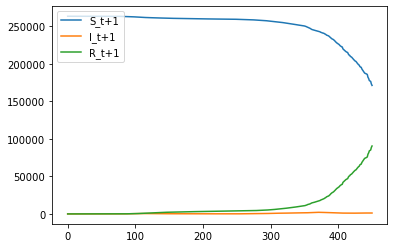

In [87]:
plt.plot(St_matrix[1769,:], label="S_t+1") # just plot node 0's susceptible over time
plt.plot(It_matrix[1769,:], label="I_t+1") # just plot node 0's infection over time
plt.plot(Rt_matrix[1769,:], label="R_t+1") # just plot node 0's recovery over time
plt.legend(loc="upper left")
plt.show()

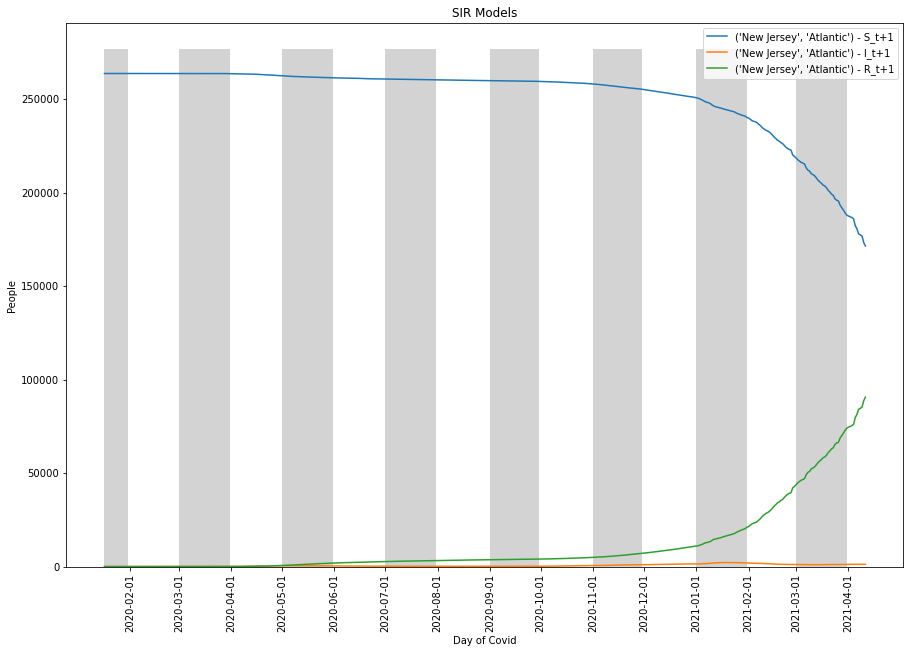

In [88]:
graph_data([regions_Array_List[1769]], 'SIR', dates_Array, St_matrix, It_matrix, Rt_matrix, beta_matrix, Et_matrix, FIPS_dictionary)

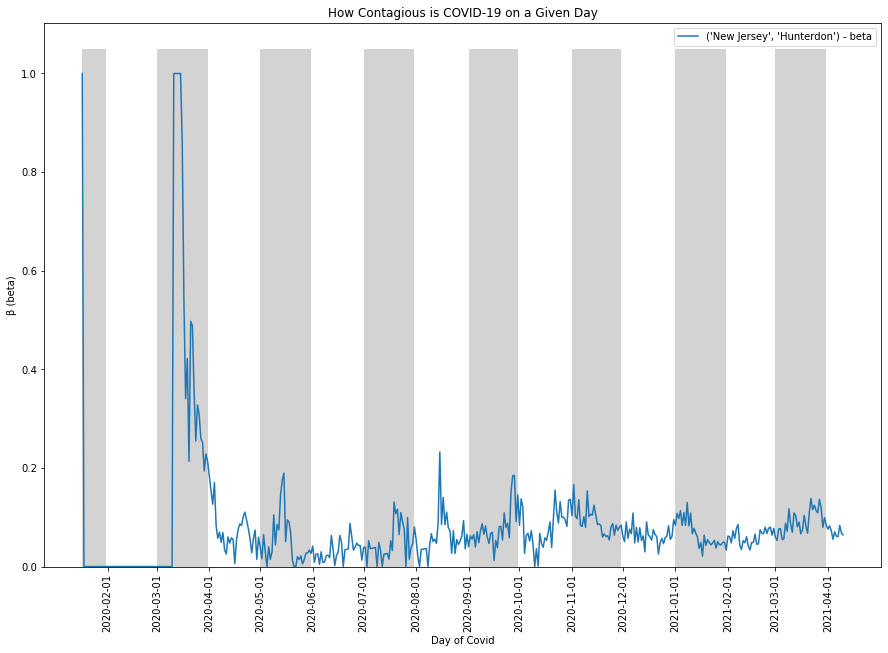

In [89]:
graph_data([regions_Array_List[1778]], 'beta', dates_Array, St_matrix, It_matrix, Rt_matrix, beta_matrix, Et_matrix, FIPS_dictionary)

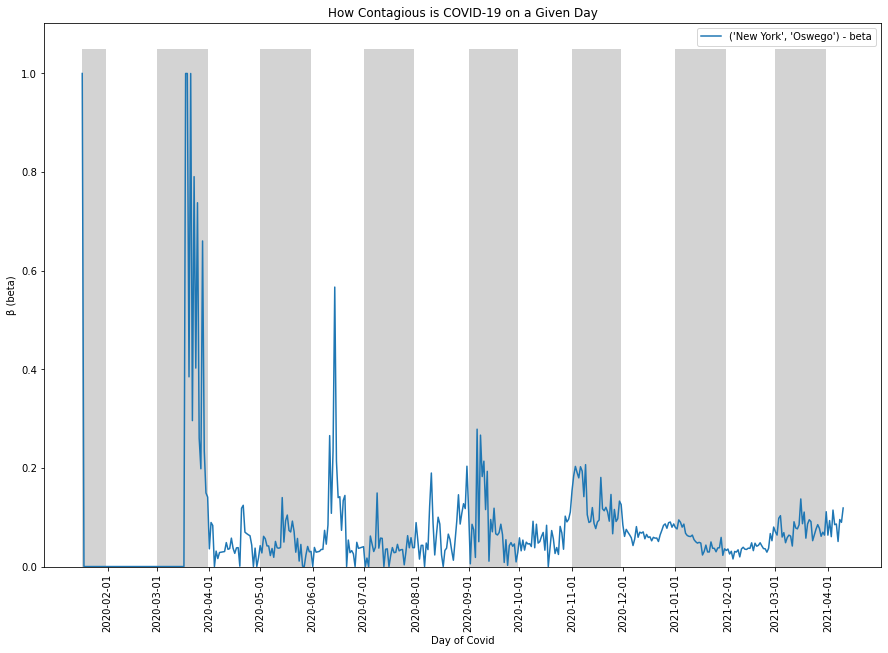

In [90]:
graph_data([regions_Array_List[1857]], 'beta', dates_Array, St_matrix, It_matrix, Rt_matrix, beta_matrix, Et_matrix, FIPS_dictionary)

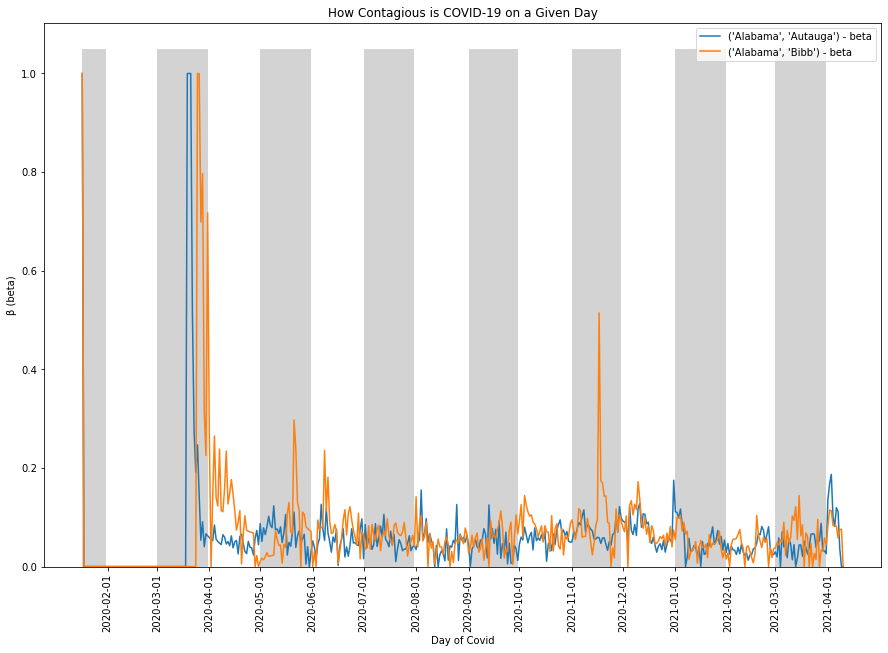

In [91]:
graph_data([regions_Array_List[0],regions_Array_List[3]], 'beta', dates_Array, St_matrix, It_matrix, Rt_matrix, beta_matrix, Et_matrix, FIPS_dictionary)

# Paper Visuals

## Build A Beta Dataframe

In [57]:
#The index 105 is the location of the date 2020-05-01, we decided to focus only on data from May onwards 
beta_dates = dates_Array[105:-1] * number_of_regions
len(beta_dates)

1080885

In [58]:
beta_fips = []
for fips in list(FIPS_dictionary.keys()):
    temp1 = list(((fips, ) * len(dates_Array[105:-1])))
    beta_fips.append(temp1)
beta_fips = [val for sublist in beta_fips for val in sublist]
len(beta_fips)

1080885

In [59]:
beta_state_county = []
beta_state = []
temp_beta_state = []
for region in regions_Array_List:
    temp1 = list(((region, ) * len(dates_Array[105:-1])))
    temp2 = list(((region[0], ) * len(dates_Array[105:-1])))
    beta_state_county.append(temp1)
    beta_state.append(temp2)
    temp_beta_state.append(region[0])
beta_state_county = [val for sublist in beta_state_county for val in sublist]
beta_state = [val for sublist in beta_state for val in sublist]
len(beta_state_county)

1080885

In [60]:
len(beta_state)

1080885

In [61]:
len(temp_beta_state)

3133

In [62]:
beta_df_list = beta_matrix[:, 105:]
beta_df_list = beta_df_list.tolist()
beta_df_list = [val for sublist in beta_df_list for val in sublist]
len(beta_df_list)

1080885

In [63]:
beta_df = pd.DataFrame(list(zip(beta_dates, beta_fips, beta_state_county, beta_state, beta_df_list)), columns=['date', 'fips', 'state,county', 'state', 'beta'])

beta_df

date   fips        state,county    state      beta
0        2020-05-01   1001  (Alabama, Autauga)  Alabama  0.087058
1        2020-05-02   1001  (Alabama, Autauga)  Alabama  0.050876
2        2020-05-03   1001  (Alabama, Autauga)  Alabama  0.078573
3        2020-05-04   1001  (Alabama, Autauga)  Alabama  0.064650
4        2020-05-05   1001  (Alabama, Autauga)  Alabama  0.081082
...             ...    ...                 ...      ...       ...
1080880  2021-04-06  56045   (Wyoming, Weston)  Wyoming  0.173650
1080881  2021-04-07  56045   (Wyoming, Weston)  Wyoming  0.258037
1080882  2021-04-08  56045   (Wyoming, Weston)  Wyoming  0.196961
1080883  2021-04-09  56045   (Wyoming, Weston)  Wyoming  0.266506
1080884  2021-04-10  56045   (Wyoming, Weston)  Wyoming  0.184443

[1080885 rows x 5 columns]

In [102]:
paper_dates = dates_Array[105:]
paper_dates

['2020-05-01',
 '2020-05-02',
 '2020-05-03',
 '2020-05-04',
 '2020-05-05',
 '2020-05-06',
 '2020-05-07',
 '2020-05-08',
 '2020-05-09',
 '2020-05-10',
 '2020-05-11',
 '2020-05-12',
 '2020-05-13',
 '2020-05-14',
 '2020-05-15',
 '2020-05-16',
 '2020-05-17',
 '2020-05-18',
 '2020-05-19',
 '2020-05-20',
 '2020-05-21',
 '2020-05-22',
 '2020-05-23',
 '2020-05-24',
 '2020-05-25',
 '2020-05-26',
 '2020-05-27',
 '2020-05-28',
 '2020-05-29',
 '2020-05-30',
 '2020-05-31',
 '2020-06-01',
 '2020-06-02',
 '2020-06-03',
 '2020-06-04',
 '2020-06-05',
 '2020-06-06',
 '2020-06-07',
 '2020-06-08',
 '2020-06-09',
 '2020-06-10',
 '2020-06-11',
 '2020-06-12',
 '2020-06-13',
 '2020-06-14',
 '2020-06-15',
 '2020-06-16',
 '2020-06-17',
 '2020-06-18',
 '2020-06-19',
 '2020-06-20',
 '2020-06-21',
 '2020-06-22',
 '2020-06-23',
 '2020-06-24',
 '2020-06-25',
 '2020-06-26',
 '2020-06-27',
 '2020-06-28',
 '2020-06-29',
 '2020-06-30',
 '2020-07-01',
 '2020-07-02',
 '2020-07-03',
 '2020-07-04',
 '2020-07-05',
 '2020-07-

# Plot #1 - 
**Line plot of I, $\beta $ pairs**

Use Function:

**beta_I_pairs_plot(desired_region, paper_dates, dates_Array, It_matrix, beta_matrix, FIPS_dictionary)**

In [65]:
FIPS_dictionary[8041]

261

In [66]:
regions_Array_List[261]

('Colorado', 'El Paso')

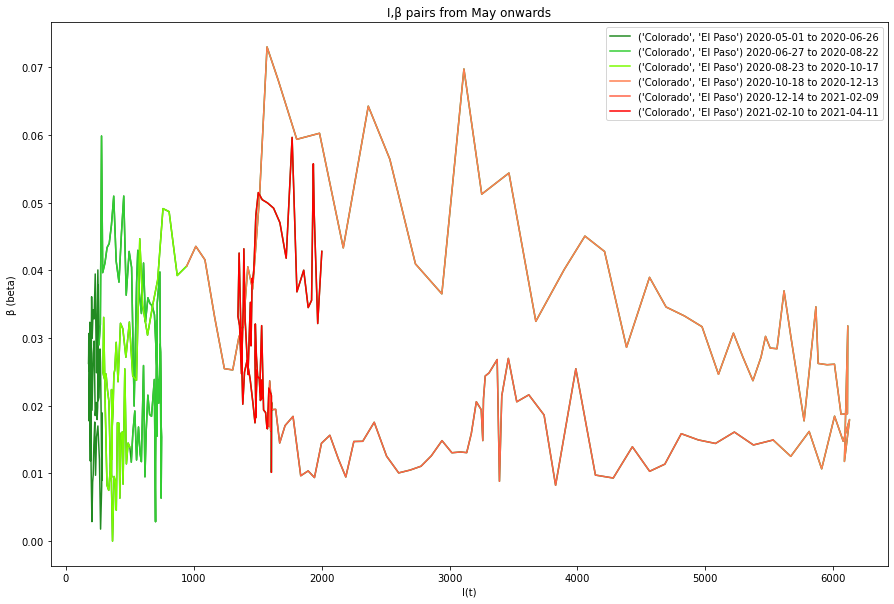

In [67]:
beta_I_pairs_plot(regions_Array_List[261], paper_dates, dates_Array, It_matrix, beta_matrix, FIPS_dictionary)

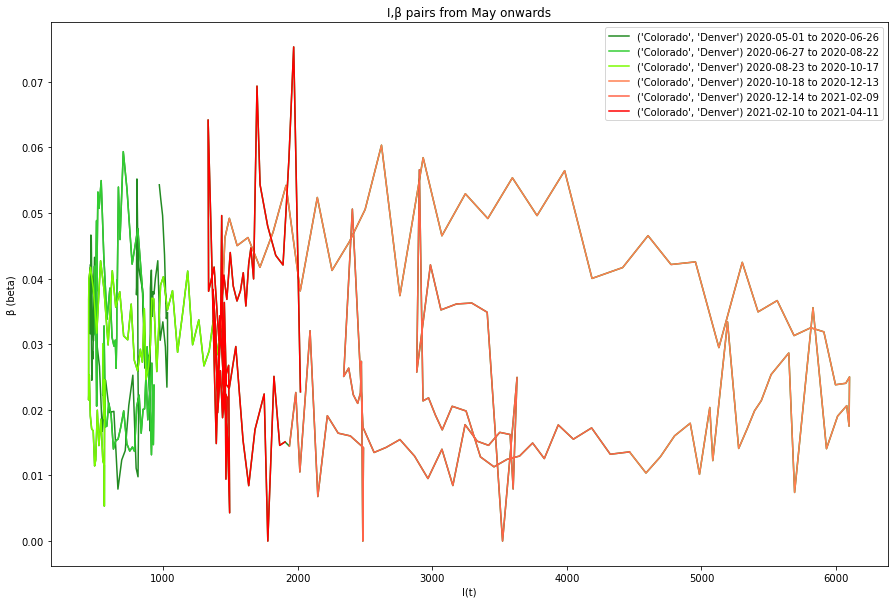

In [68]:
beta_I_pairs_plot(regions_Array_List[256], paper_dates, dates_Array, It_matrix, beta_matrix, FIPS_dictionary)

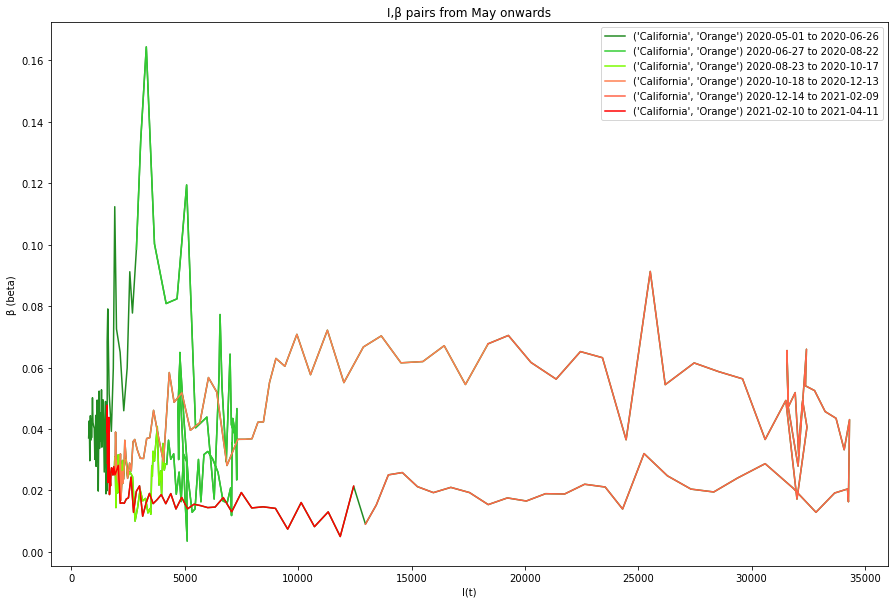

In [69]:
beta_I_pairs_plot(regions_Array_List[211], paper_dates, dates_Array, It_matrix, beta_matrix, FIPS_dictionary)

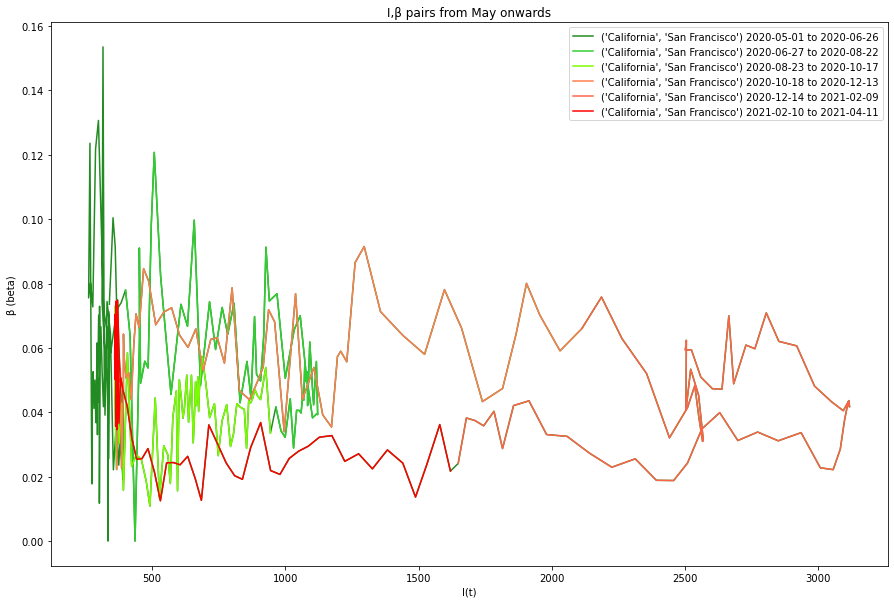

In [70]:
beta_I_pairs_plot(regions_Array_List[219], paper_dates, dates_Array, It_matrix, beta_matrix, FIPS_dictionary)

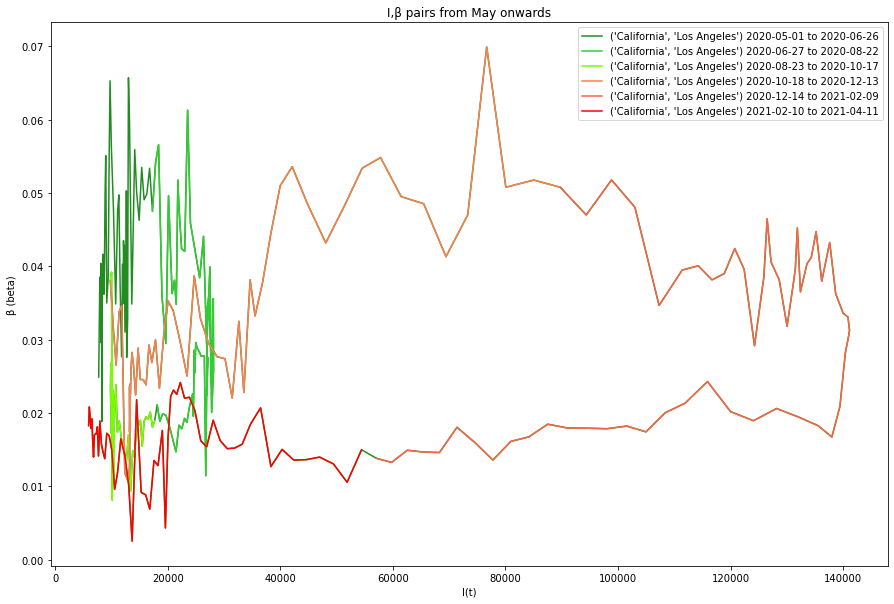

In [71]:
beta_I_pairs_plot(regions_Array_List[200], paper_dates, dates_Array, It_matrix, beta_matrix, FIPS_dictionary)

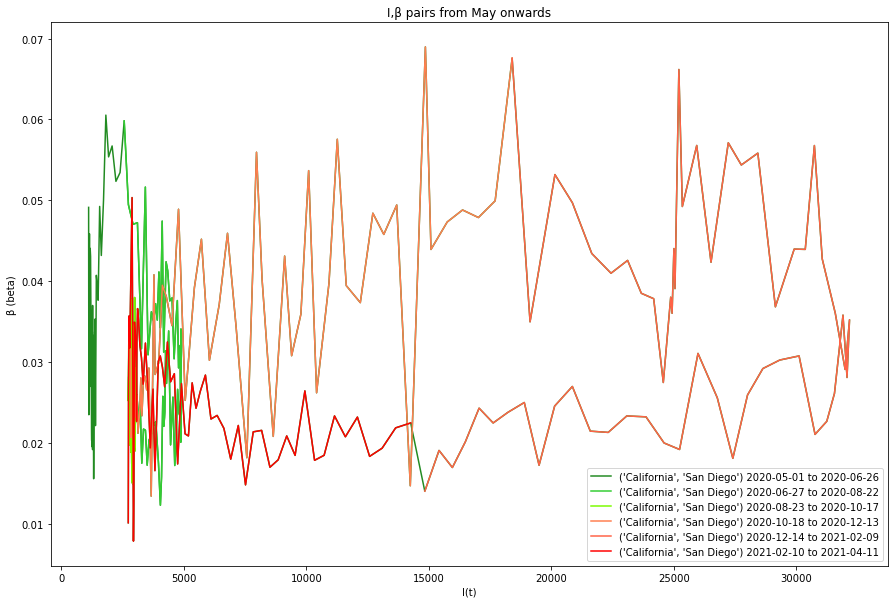

In [72]:
beta_I_pairs_plot(regions_Array_List[218], paper_dates, dates_Array, It_matrix, beta_matrix, FIPS_dictionary)

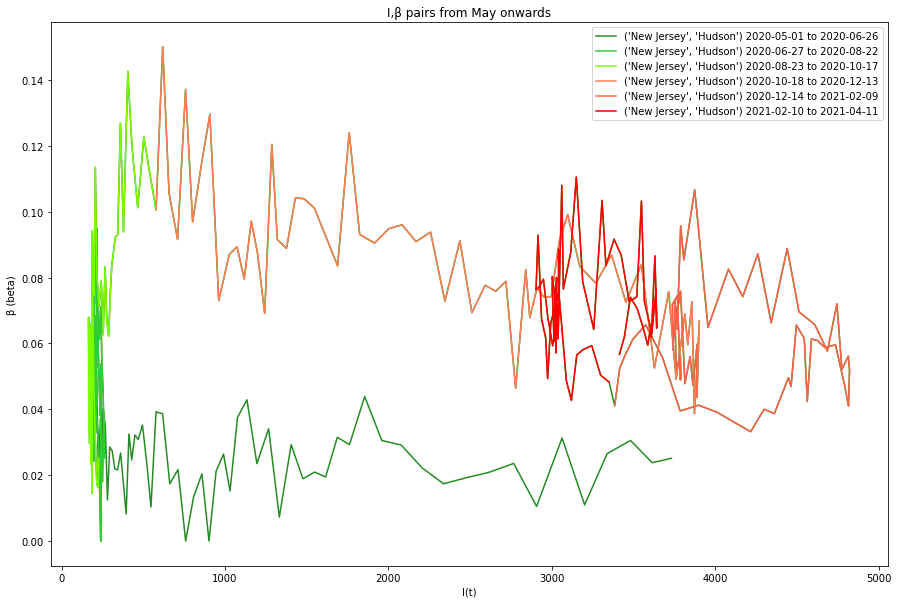

In [73]:
beta_I_pairs_plot(regions_Array_List[1777], paper_dates, dates_Array, It_matrix, beta_matrix, FIPS_dictionary)

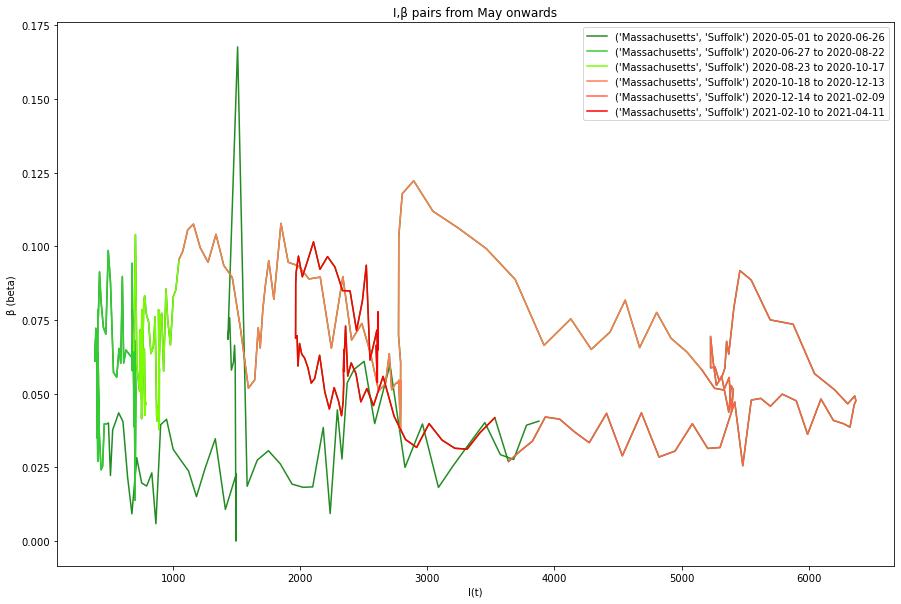

In [74]:
beta_I_pairs_plot(regions_Array_List[1224], paper_dates, dates_Array, It_matrix, beta_matrix, FIPS_dictionary)

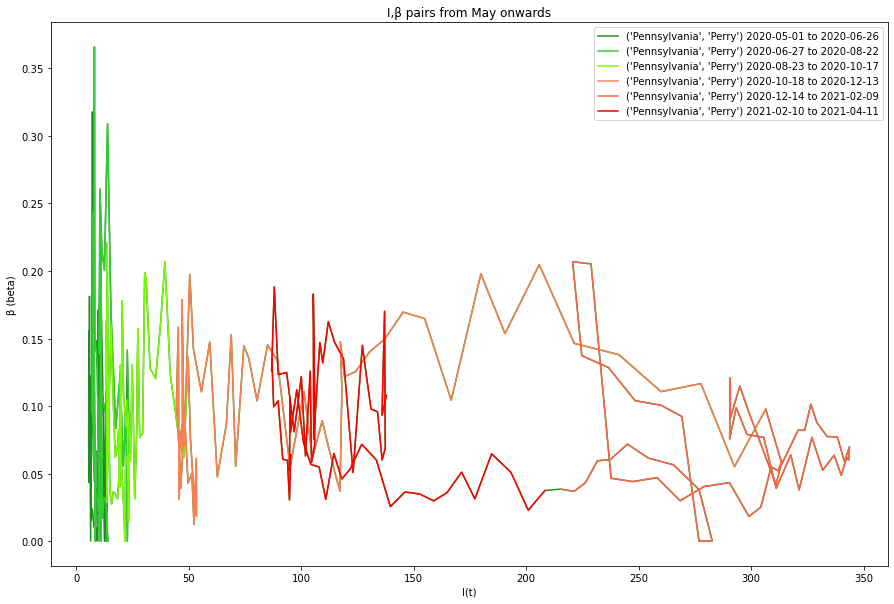

In [75]:
beta_I_pairs_plot(regions_Array_List[2284], paper_dates, dates_Array, It_matrix, beta_matrix, FIPS_dictionary)

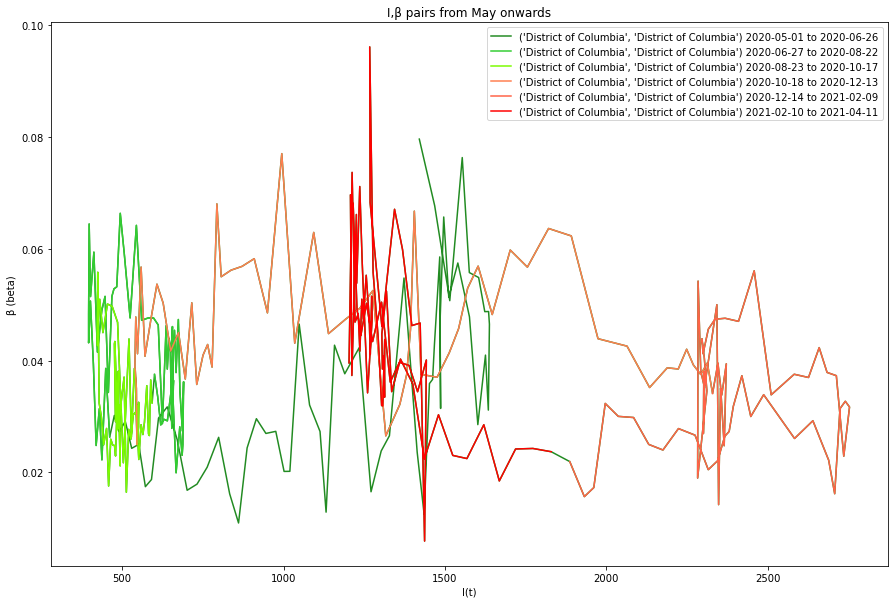

In [76]:
beta_I_pairs_plot(regions_Array_List[315], paper_dates, dates_Array, It_matrix, beta_matrix, FIPS_dictionary)

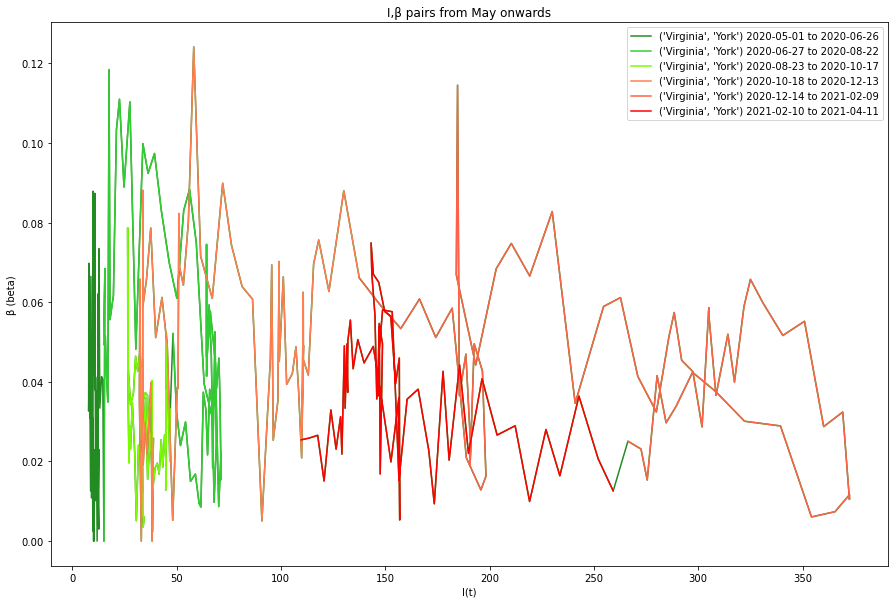

In [77]:
beta_I_pairs_plot(regions_Array_List[2905], paper_dates, dates_Array, It_matrix, beta_matrix, FIPS_dictionary)

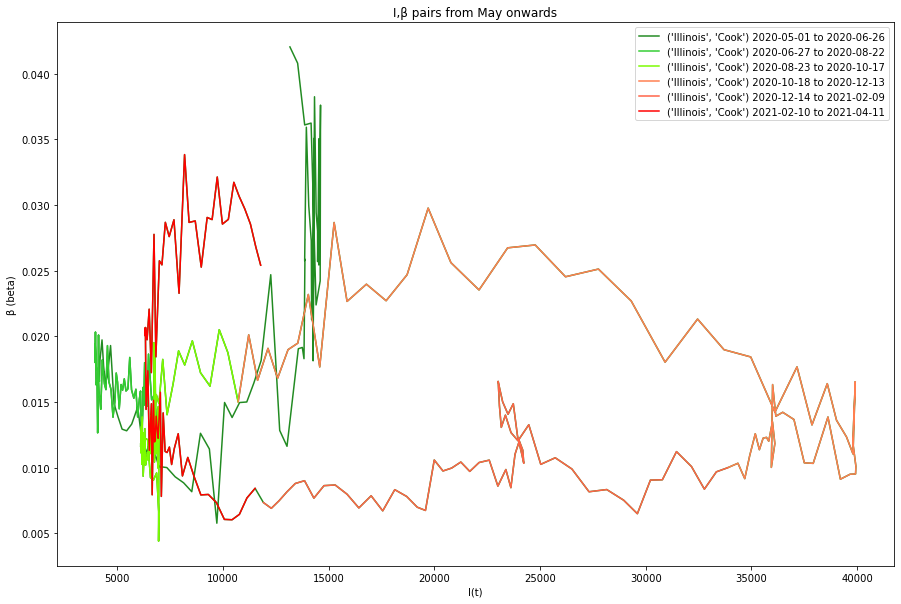

In [78]:
beta_I_pairs_plot(regions_Array_List[605], paper_dates, dates_Array, It_matrix, beta_matrix, FIPS_dictionary)

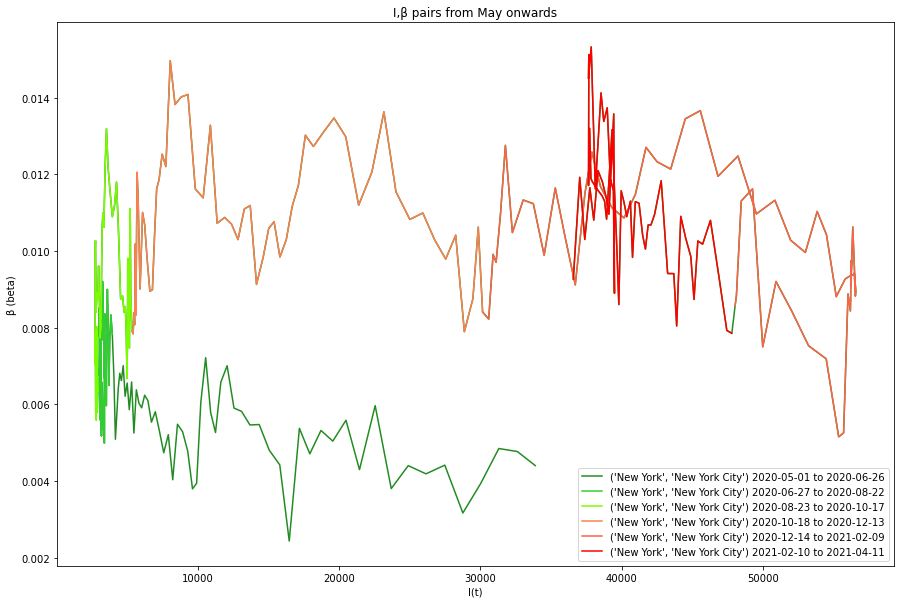

In [79]:
beta_I_pairs_plot(regions_Array_List[1880], paper_dates, dates_Array, It_matrix, beta_matrix, FIPS_dictionary)

# Plot #2 - 
**Daily average for $\beta$ for whole US**

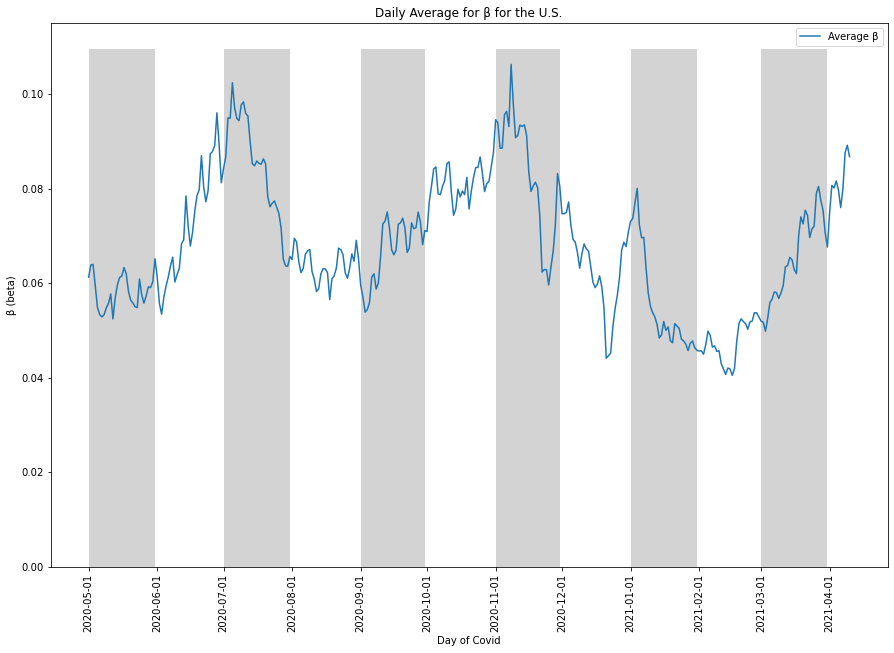

In [81]:
fig, ax = plt.subplots(figsize=(15,10))

plt.plot(np.average(beta_matrix[:, 105:], axis=0), label = "Average \u03B2")

dates_indices = []
    
first_dates = (pd.date_range(dates_Array[105], dates_Array[-1], freq='1M') - pd.offsets.MonthBegin(1)).strftime('%Y-%m-%d').to_list()
first_dates.append(dates_Array[-11])
   
#below I get the index of the first day of each month
for i in first_dates:
    dates_indices.append(paper_dates.index(i))
    
ax.set_xticks(dates_indices)
ax.set_xticklabels(first_dates)

max_y_value = ax.get_ylim()[1]
      
#below is code to create light and dark bars for where a month starts and ends
x = 0
for i in range(6):
    width_value = (dates_indices[x+1] - 1) - dates_indices[x]
    ax.bar(dates_indices[x], max_y_value, color='lightgrey', width=width_value, align='edge')
    x = x + 2
        
plt.legend(loc="upper left")
plt.title('Daily Average for \u03B2 for the U.S.')   
plt.ylabel('\u03B2 (beta)')
plt.xlabel('Day of Covid')
plt.xticks(rotation = 90)
plt.legend()
plt.show()

# Plot #3 - 
**Daily average for $\beta$ for counties**

Use Function: 

**county_daily_average(desired_region, dates_Array, beta_matrix, FIPS_dictionary)**

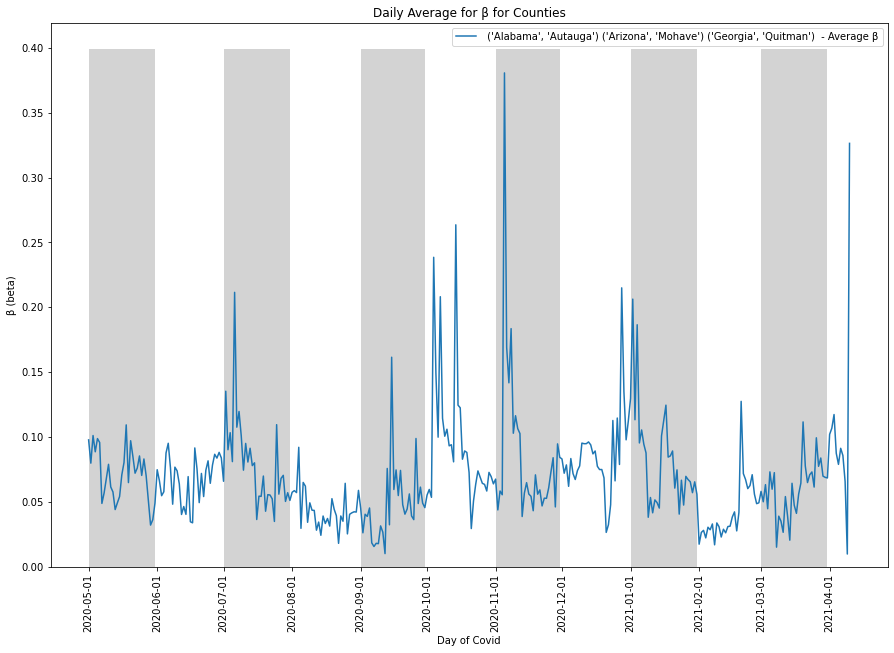

In [82]:
#take given counties and compute daily average for beta 
county_daily_average([regions_Array_List[0], regions_Array_List[100], regions_Array_List[500]], dates_Array, beta_matrix, FIPS_dictionary)

# Plot #4 - 
**Daily average for $\beta$ for states**

Use Function: 

**def state_daily_average(temp_beta_state, desired_states, dates_Array, beta_matrix, FIPS_dictionary)**

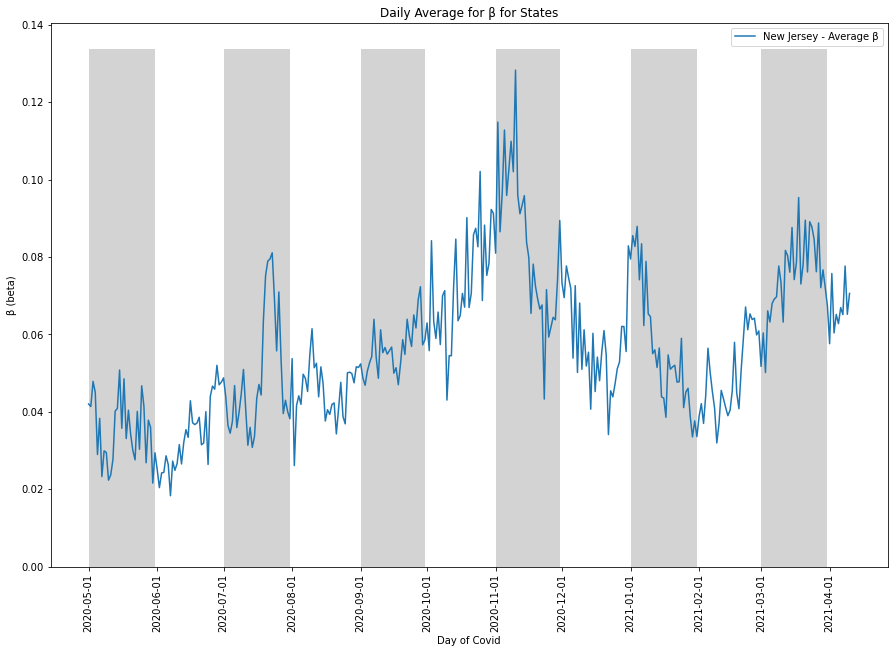

In [83]:
state_daily_average(temp_beta_state, ['New Jersey'], dates_Array, beta_matrix, FIPS_dictionary)

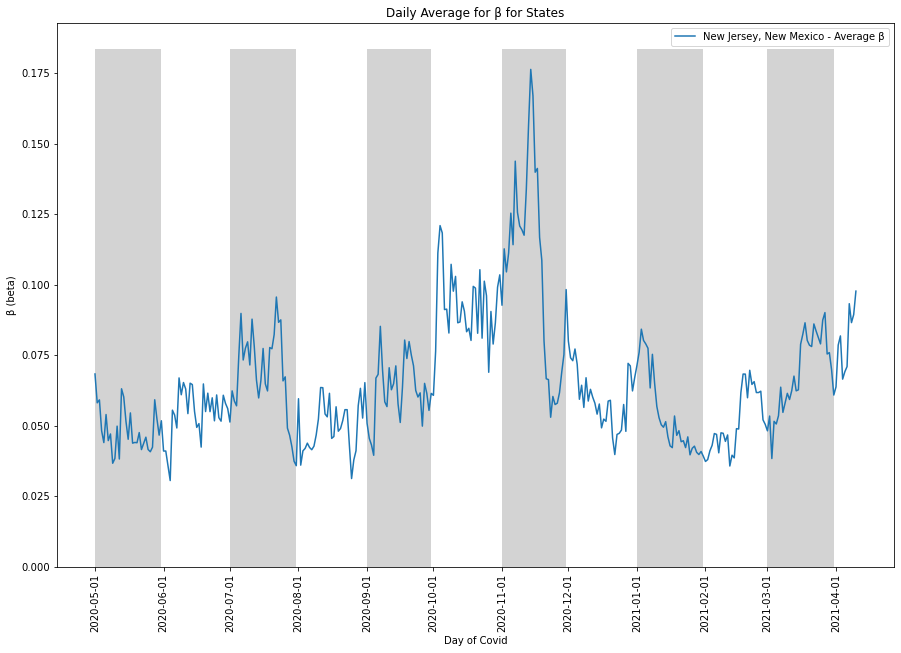

In [84]:
#take all the counties in NJ and NM and compute daily average for beta
state_daily_average(temp_beta_state, ['New Jersey', 'New Mexico'], dates_Array, beta_matrix, FIPS_dictionary)

# Plot #5 - 
**Daily average for $\beta$ for 4 states in the North and 4 states in the South**

Use Function:

**separate_state_daily_average(temp_beta_state, desired_states1, desired_states2, dates_Array, beta_matrix, FIPS_dictionary)**

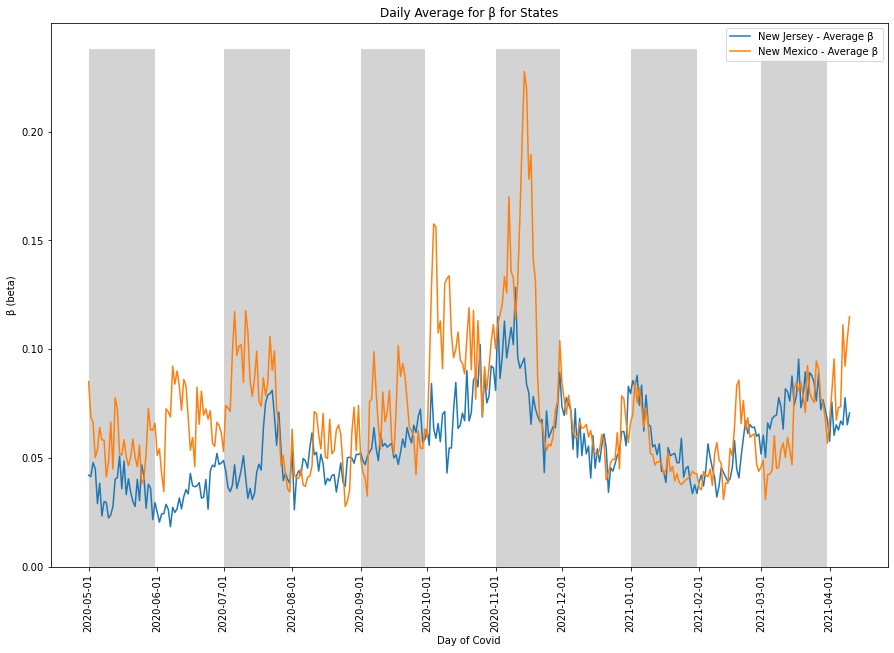

In [85]:
compare_state_daily_average(temp_beta_state, ['New Jersey'], ['New Mexico'], dates_Array, beta_matrix, FIPS_dictionary) 

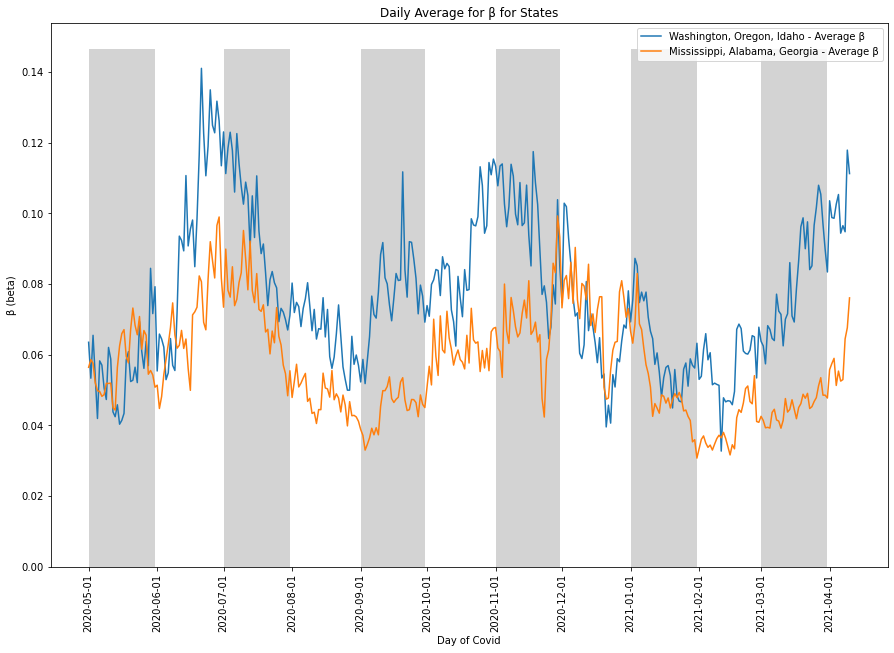

In [86]:
#Noth vs. South
compare_state_daily_average(temp_beta_state, ['Washington', 'Oregon', 'Idaho'], ['Mississippi', 'Alabama', 'Georgia'], dates_Array, beta_matrix, FIPS_dictionary) 

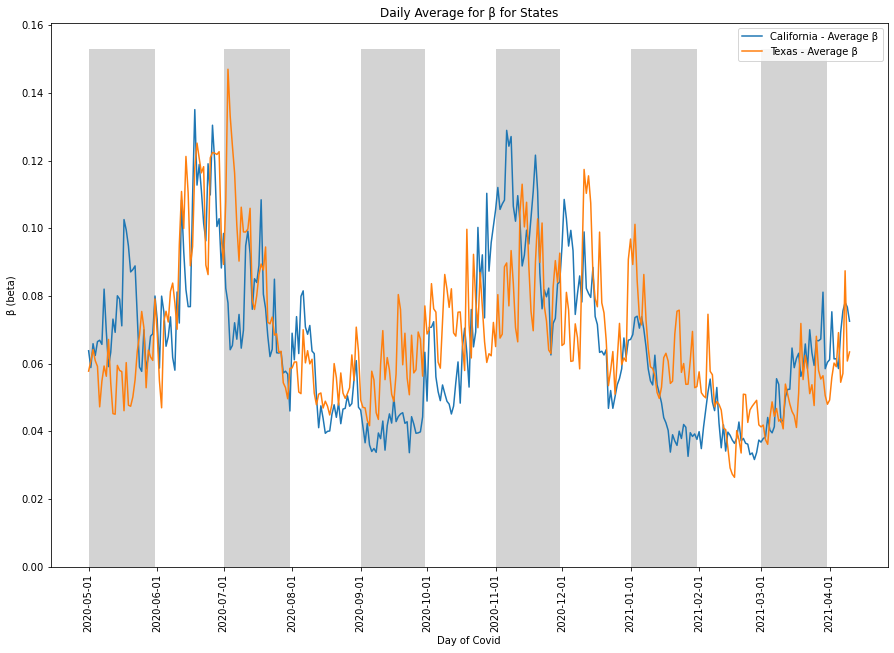

In [87]:
compare_state_daily_average(temp_beta_state, ['California'], ['Texas'], dates_Array, beta_matrix, FIPS_dictionary) 

In [88]:
#Enter FIPS code to get index of S, E, I, R, or beta matrix
print(FIPS_dictionary[34001])
print(regions_Array_List[1769])

1769
('New Jersey', 'Atlantic')


In [89]:
#Enter FIPS code to get index of S, E, I, R, or beta matrix
print(FIPS_dictionary[36998])
print(regions_Array_List[1880])

1880
('New York', 'New York City')


# Plot #6 - 
**Scatter plot of Sum of mobility, $\beta $ pairs**

Use Function:

**beta_sum_of_mobility_plot(desired_region, paper_dates, sum_of_mobility_matrix, beta_matrix, FIPS_dictionary)**

# Plot #7 - 
**Scatter plot of Sum of mobility, $\beta $ pairs, but split in a way that matches the green and red above**

Use Function:

**split_beta_sum_of_mobility_plot(desired_region, paper_dates, sum_of_mobility_matrix, beta_matrix, FIPS_dictionary)**

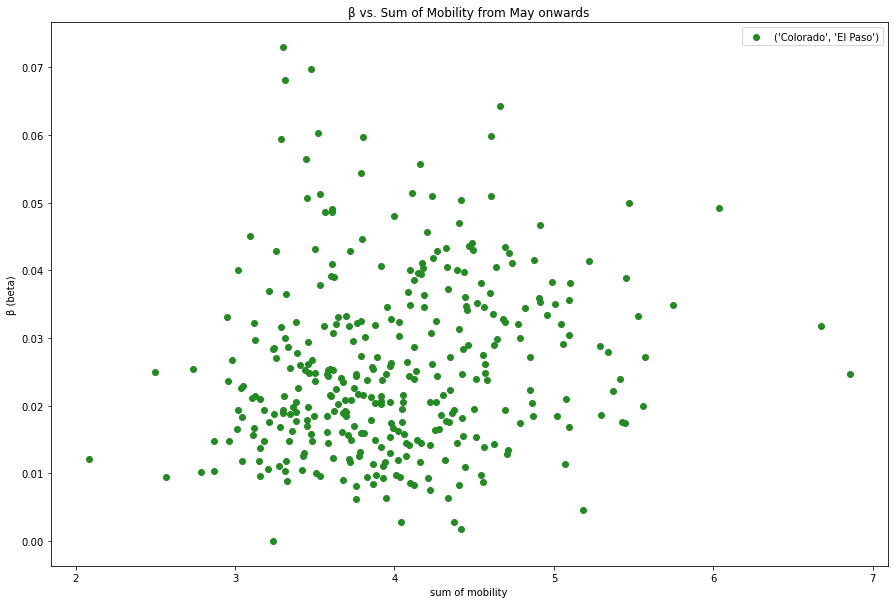

In [90]:
beta_sum_of_mobility_plot(regions_Array_List[261], paper_dates, sum_of_mobility_matrix, beta_matrix, FIPS_dictionary)  

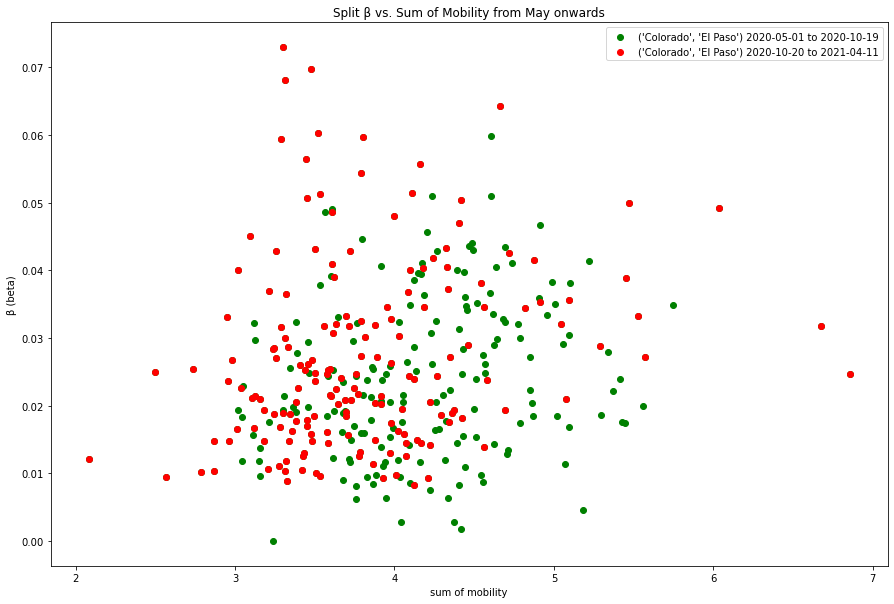

In [91]:
split_beta_sum_of_mobility_plot(regions_Array_List[261], paper_dates, sum_of_mobility_matrix, beta_matrix, FIPS_dictionary)

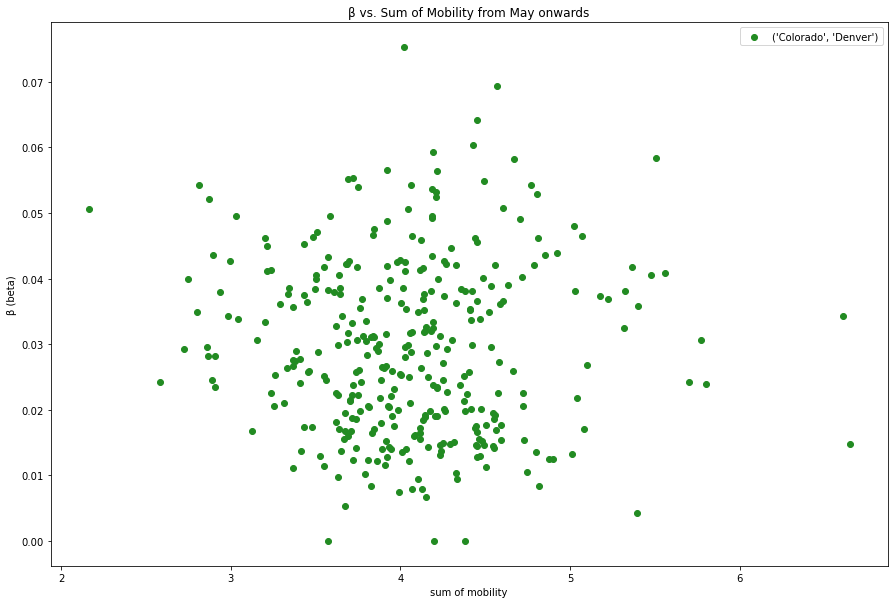

In [92]:
beta_sum_of_mobility_plot(regions_Array_List[256], paper_dates, sum_of_mobility_matrix, beta_matrix, FIPS_dictionary)  

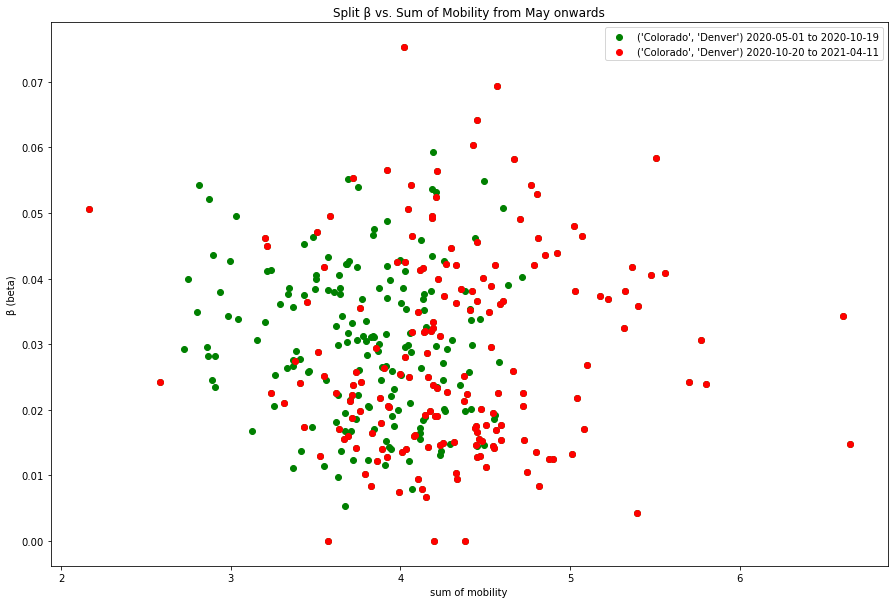

In [93]:
split_beta_sum_of_mobility_plot(regions_Array_List[256], paper_dates, sum_of_mobility_matrix, beta_matrix, FIPS_dictionary)

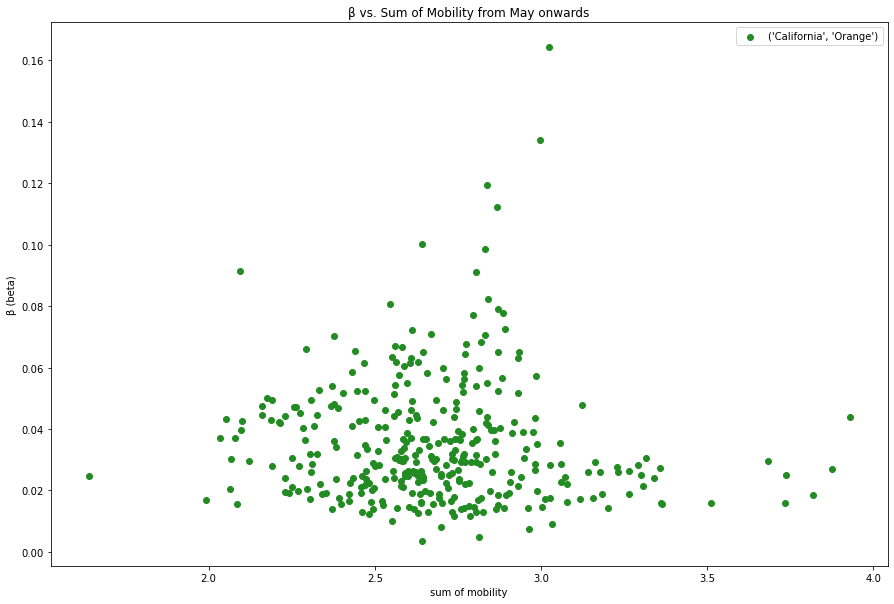

In [94]:
beta_sum_of_mobility_plot(regions_Array_List[211], paper_dates, sum_of_mobility_matrix, beta_matrix, FIPS_dictionary)  

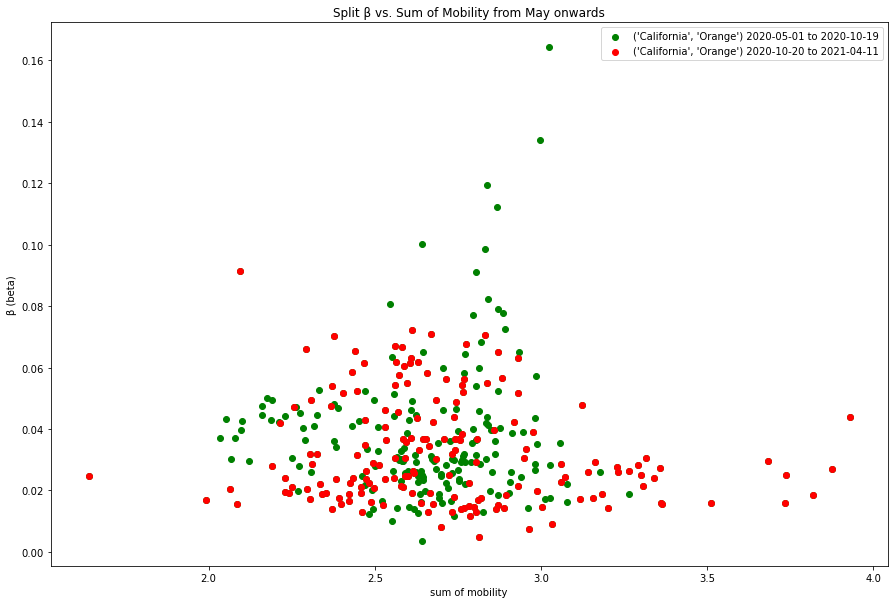

In [95]:
split_beta_sum_of_mobility_plot(regions_Array_List[211], paper_dates, sum_of_mobility_matrix, beta_matrix, FIPS_dictionary)

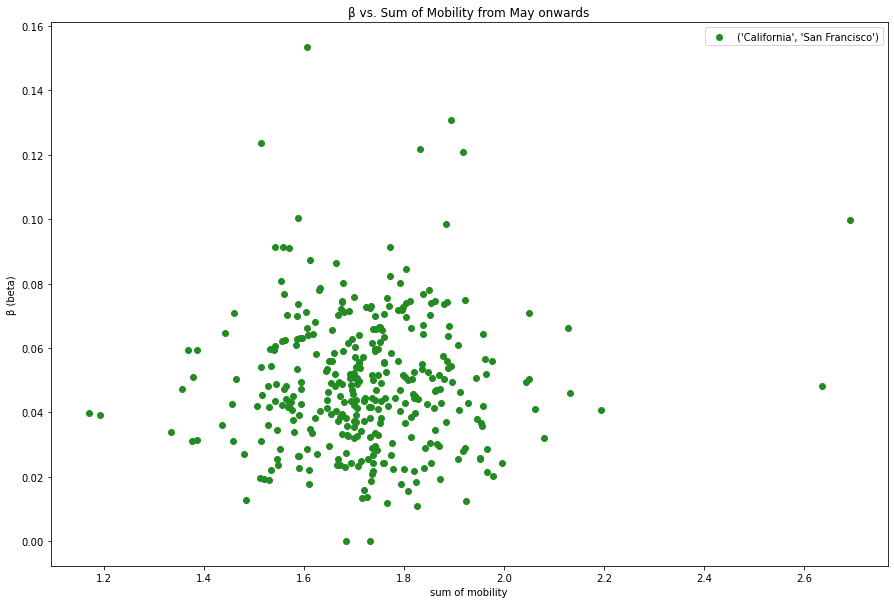

In [96]:
beta_sum_of_mobility_plot(regions_Array_List[219], paper_dates, sum_of_mobility_matrix, beta_matrix, FIPS_dictionary)  

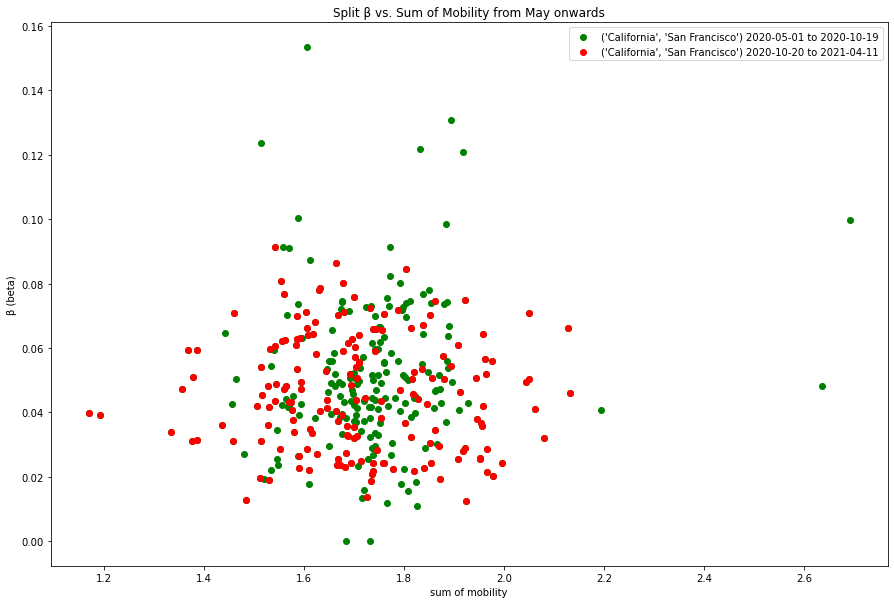

In [97]:
split_beta_sum_of_mobility_plot(regions_Array_List[219], paper_dates, sum_of_mobility_matrix, beta_matrix, FIPS_dictionary)

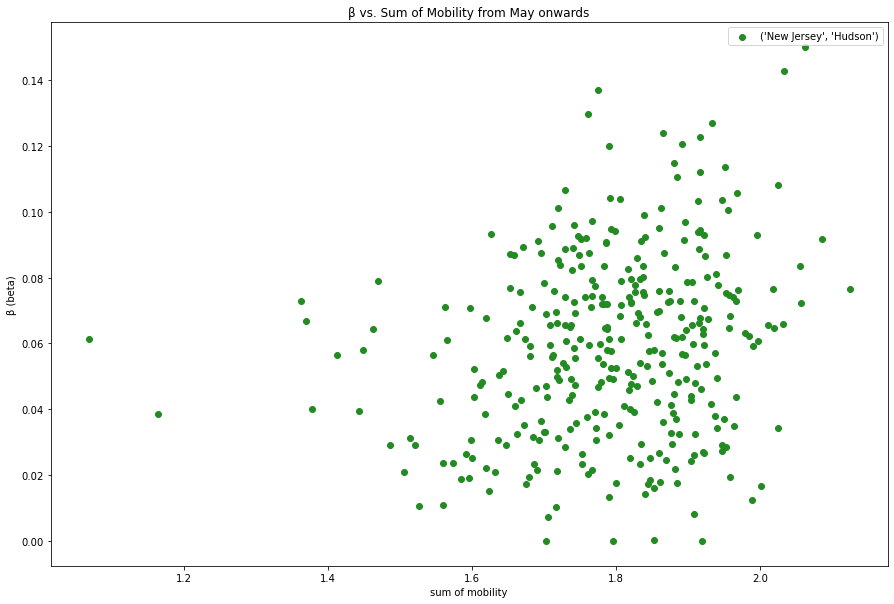

In [98]:
beta_sum_of_mobility_plot(regions_Array_List[1777], paper_dates, sum_of_mobility_matrix, beta_matrix, FIPS_dictionary)  

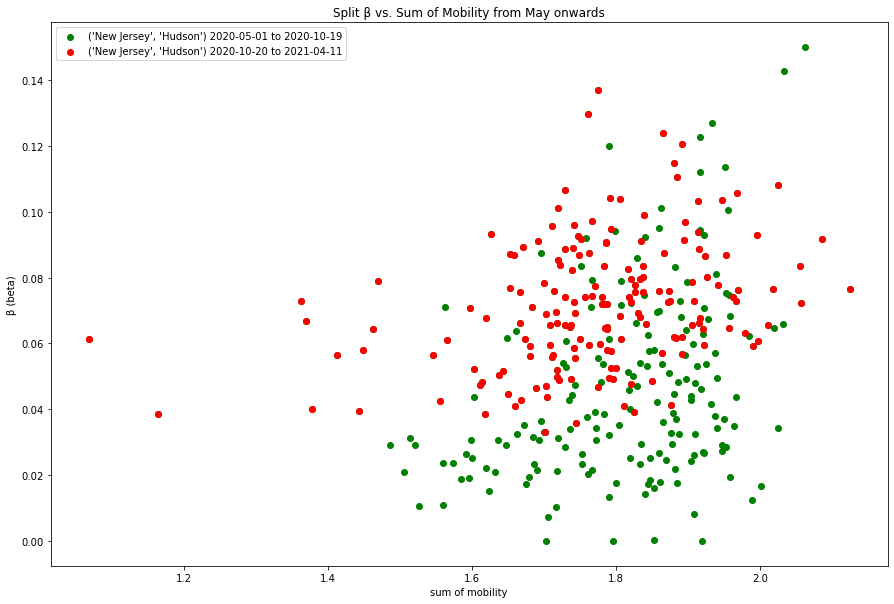

In [99]:
split_beta_sum_of_mobility_plot(regions_Array_List[1777], paper_dates, sum_of_mobility_matrix, beta_matrix, FIPS_dictionary)

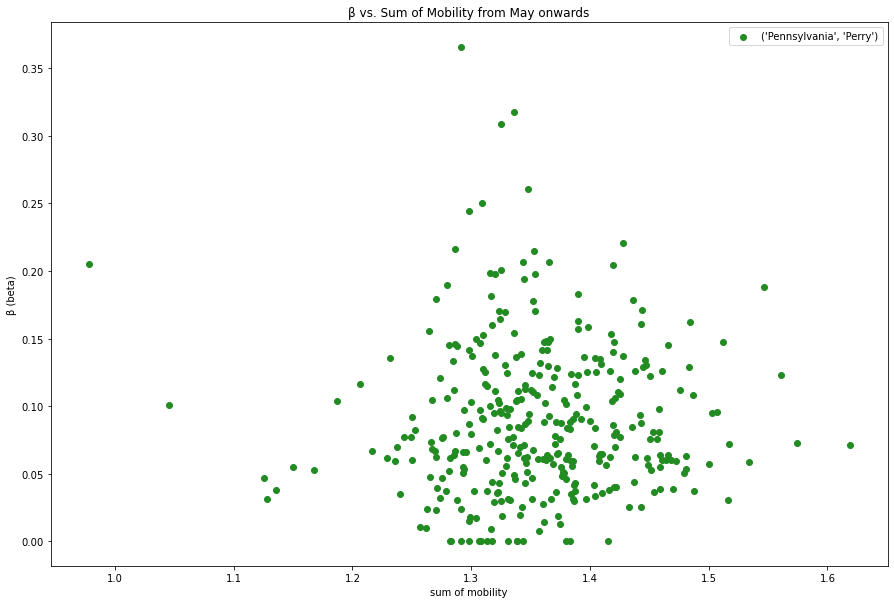

In [100]:
beta_sum_of_mobility_plot(regions_Array_List[2284], paper_dates, sum_of_mobility_matrix, beta_matrix, FIPS_dictionary)  

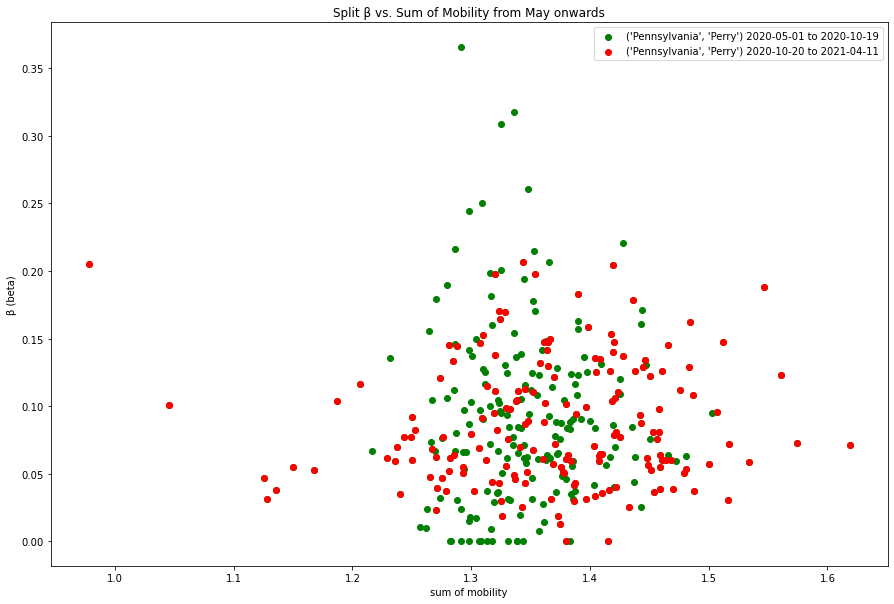

In [101]:
split_beta_sum_of_mobility_plot(regions_Array_List[2284], paper_dates, sum_of_mobility_matrix, beta_matrix, FIPS_dictionary)

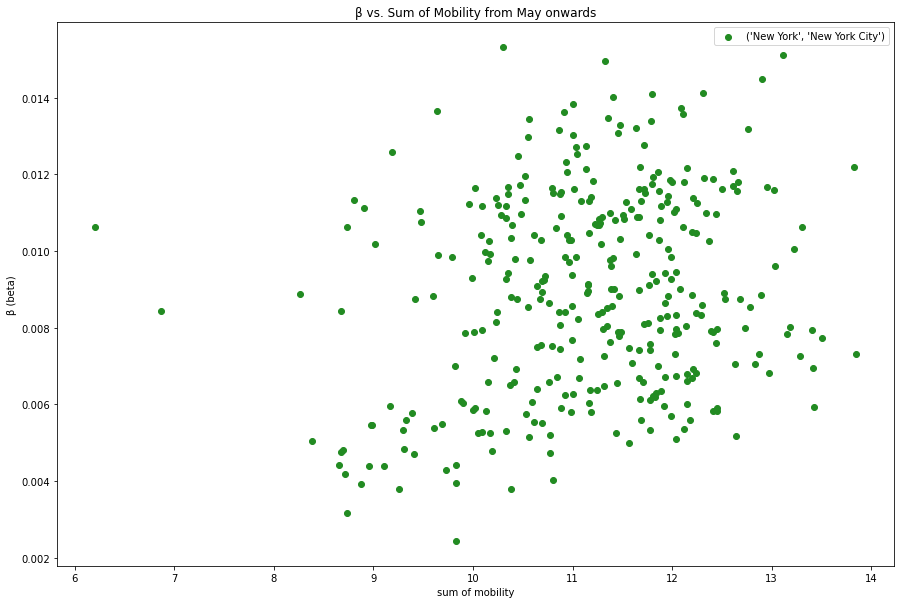

In [159]:
beta_sum_of_mobility_plot(regions_Array_List[1880], paper_dates, sum_of_mobility_matrix, beta_matrix, FIPS_dictionary)  

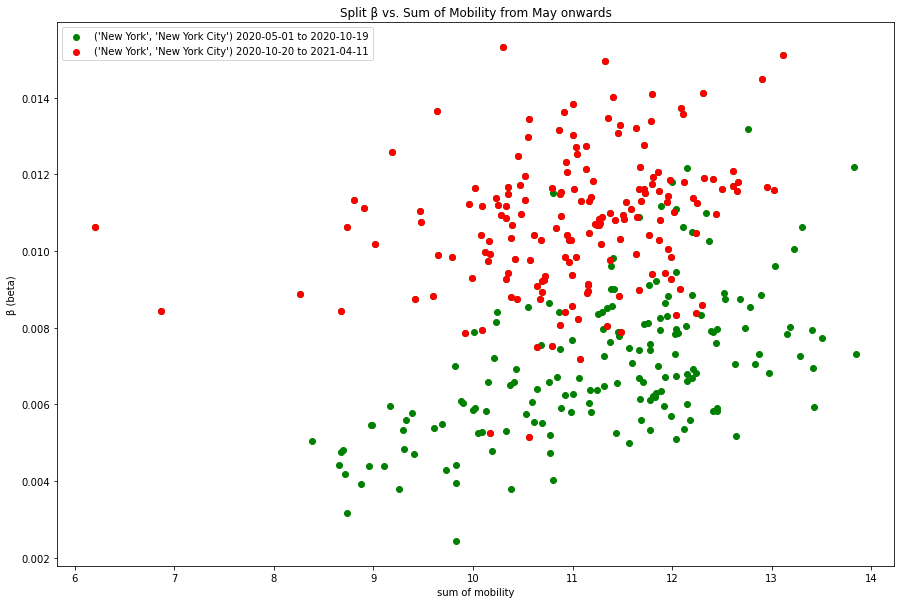

In [102]:
split_beta_sum_of_mobility_plot(regions_Array_List[1880], paper_dates, sum_of_mobility_matrix, beta_matrix, FIPS_dictionary)

# Plot #8 - Daily Mobility of Outgoing flows vs. Day of COVID

Use Function:

**daily_mobility_plot(desired_region, dates_Array, sum_of_mobility_matrix, FIPS_dictionary)**

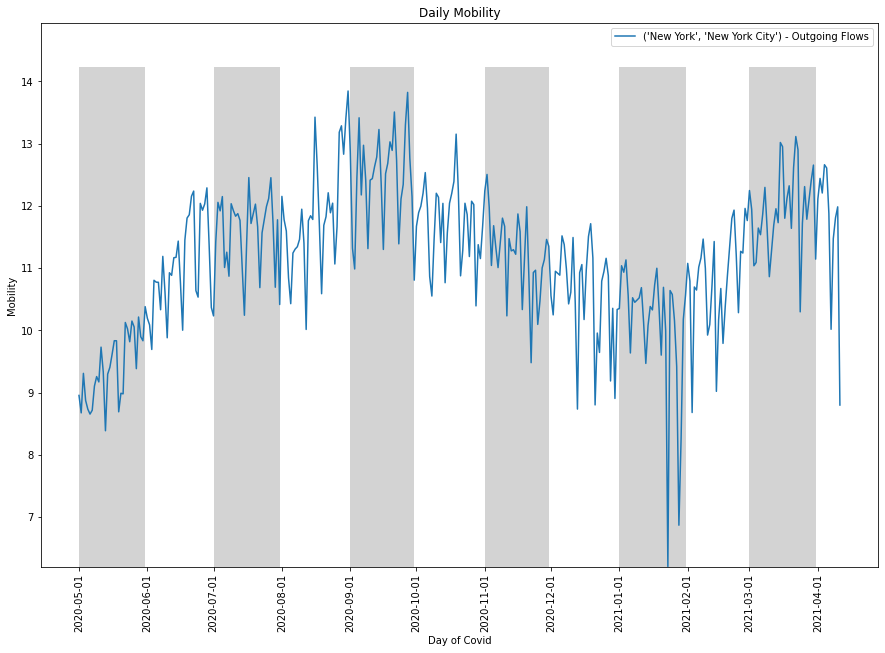

In [103]:
daily_mobility_plot(regions_Array_List[1880], dates_Array, sum_of_mobility_matrix, FIPS_dictionary)

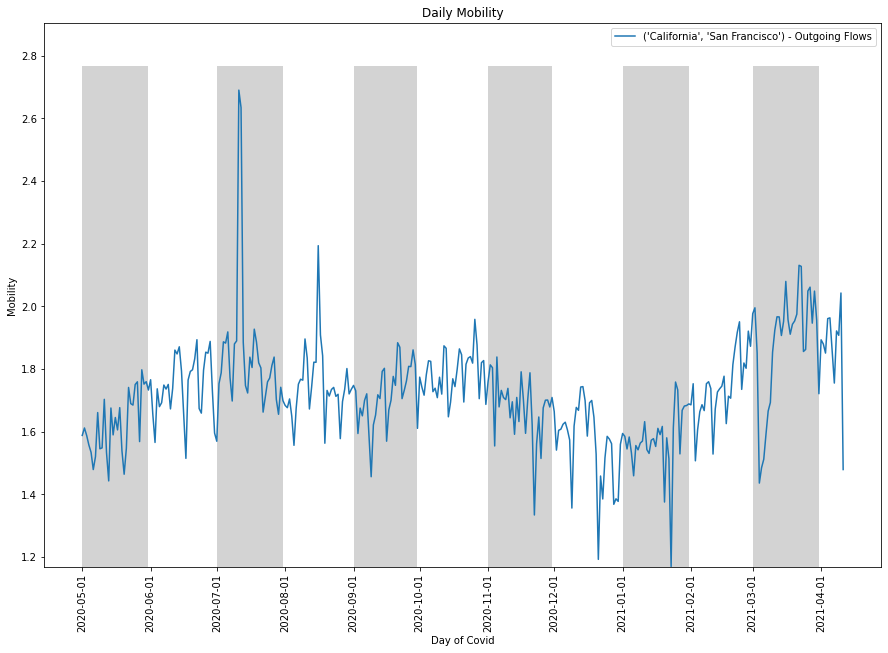

In [104]:
daily_mobility_plot(regions_Array_List[219], dates_Array, sum_of_mobility_matrix, FIPS_dictionary)

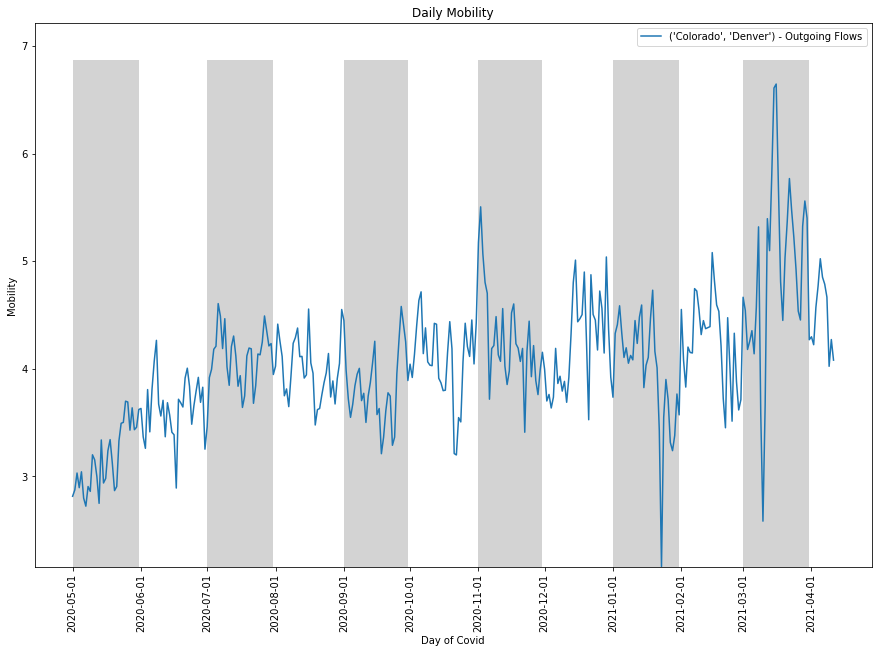

In [105]:
daily_mobility_plot(regions_Array_List[256], dates_Array, sum_of_mobility_matrix, FIPS_dictionary)

# Create CSVs with Beta vs. Sum of Mobility scatter Plot data

Use Function:

**create_CSV_of_beta_sum_of_mobility_data(desired_region, paper_dates, sum_of_mobility_matrix, beta_matrix, FIPS_dictionary)**

Below I create for CSVs for the 7 counties we have been focusing on, their Beta vs. Sum of Mobility scatter plots are above

Counties - 

('Colorado', 'El Paso')

('Colorado', 'Denver')

('California', 'Orange')

('California', 'San Francisco')

('New Jersey', 'Hudson')

('Pennsylvania', 'Perry')

('New York', 'New York City')

In [103]:
scatter_plot_data_regions = [regions_Array_List[261], regions_Array_List[256], regions_Array_List[211], regions_Array_List[219], regions_Array_List[1777], regions_Array_List[2284], regions_Array_List[1880]]

for region in scatter_plot_data_regions:
    create_CSV_of_beta_sum_of_mobility_data(region, paper_dates, sum_of_mobility_matrix, beta_matrix, FIPS_dictionary)

Complete!
Complete!
Complete!
Complete!
Complete!
Complete!
Complete!
